In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wandb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,classification_report,f1_score, precision_score, recall_score
import seaborn as sns
import math

In [2]:
df = pd.read_csv('Data/WineQT.csv')
y = pd.get_dummies(df['quality'])
categories,counts = np.unique(df['quality'],return_counts = True)
y = np.where(y == True,1.0,0.0)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,2
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,3
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1592
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1593
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1594
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1595


#  Dataset Analysis and Preprocessing
- We have splitted the data into 70% train, 15% validation and 15% test
- for normalising the data we have used standardscalar of the sklearn which transforms each attribute by so that the mean and variance for that feature in the data space are 0 and 1 respectively. This helps in convergence and bringing all features down to same scale so that they dont influence the gradient descent more than they should

In [3]:
stats= (df.describe()).loc[["mean","std","min","max"]]
stats

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


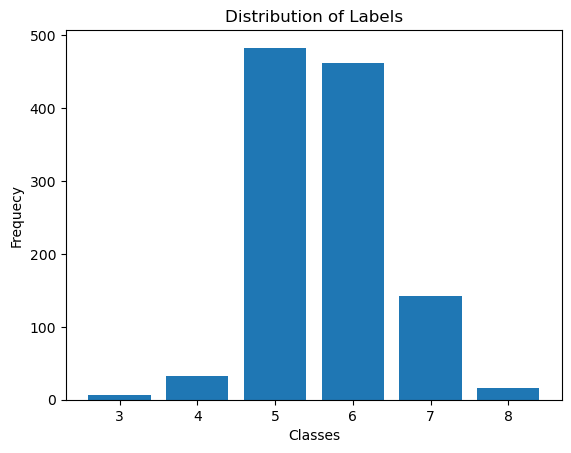

In [4]:
plt.bar(categories,counts)
plt.title('Distribution of Labels')
plt.xlabel('Classes')
plt.ylabel('Frequecy')
plt.show()

In [5]:
x_train, x_rest, y_train, y_rest = train_test_split(df.iloc[:,:-2], y, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_rest, y_rest, test_size=0.5, random_state=42)
scalar = StandardScaler()
scalar.fit(x_train.values)
x_train = scalar.transform(x_train.values)
x_val = scalar.transform(x_val.values)
x_test = scalar.transform(x_test.values)

# 2.1

In [6]:
def Xent(y_true,y_pred):
    eps = 1e-08
    return -np.sum(y_true*np.log(y_pred)) / len(y_true)

def tanh(y):
    return (np.exp(y)-np.exp(-y)) / (np.exp(y)+np.exp(-y))

def relu(y):
    return np.where(y >= 0,y,0.0)

def sigmoid(y):
    return 1 / (1 + np.exp(-y))

def Softmax(y):
    total = np.exp(y)
    return total / np.sum(total,axis =1,keepdims = True)

class MLP:
    def __init__(self,input_size,output_size,num_layers,layer_sizes,activations,optimiser = 'batch',lr = 0.01):
        self.lr = lr
        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.layer_sizes = layer_sizes
        self.activations = activations
        self.optimiser = optimiser
#         Initialising weights and biases
        self.w_and_b = []
        prev_size = input_size
        for layer in range(num_layers):
            self.w_and_b.append(0.1*np.random.rand(layer_sizes[layer],prev_size+1))
            prev_size = layer_sizes[layer]
        self.w_and_b.append(np.random.rand(output_size,prev_size+1))
                            
        self.layer_inputs = []    
        self.layer_outputs = []
        self.out = np.zeros(output_size)
    
    def tanh_grad(self,z):
        return 1 - tanh(z)**2
    
    def relu_grad(self,z):
        return np.where(z > 0,1.0,0.0)
                            
    def sigmoid_grad(self,z):
        return sigmoid(z)*(1 - sigmoid(z))
    
    def XentGrad(self,y_true,y_pred):
        eps = 1e-15
        return -(1/len(y_true))*(y_true/(y_pred+eps))                       
    
    def softmax_jacobian(self,p):
        n = p.shape[1]
        jacobian = np.zeros((len(p),n, n))
        
        for sample in range(len(p)):
            for i in range(n):
                for j in range(n):
                    if i == j:
                        jacobian[sample,i, j] = p[sample,i] * (1 - p[sample,i])
                    else:
                        jacobian[sample,i, j] = -p[sample,i] * p[sample,j]

        return jacobian
        
    def forward(self,x):
        inp = np.append(x,np.ones((x.shape[0],1)),axis=1)
        for layer in range(self.num_layers):    
            self.layer_inputs.append(inp) # (914,12)
            z = inp @ self.w_and_b[layer].T
            y = (self.activations[layer])(z)
            self.layer_outputs.append(z)
            inp = np.append(y,np.ones((y.shape[0],1)),axis=1)

        self.layer_inputs.append(inp) # (914,12)
        z = inp @ self.w_and_b[self.num_layers].T
        self.layer_outputs.append(z)
        y_prob = Softmax(z) 
        self.out = y_prob
        return y_prob
    
    def backward(self,y_true):
        w_and_b_gradients = []
        grad_y_prob = self.XentGrad(y_true,self.out) # (914,7)
        grad_y_linear = np.vectorize(lambda jac,grad: np.dot(jac,grad),signature='(n,n),(n)->(n)')(self.softmax_jacobian(self.out),grad_y_prob)  # (batch,output)
        grad_w_and_b = grad_y_linear.T @ self.layer_inputs[-1]
        w_and_b_gradients.append(grad_w_and_b)
        grad_y = grad_y_linear@self.w_and_b[-1][:,:-1]
        for layer in range(self.num_layers-1,-1,-1):
            grad_z = []
            if(self.activations[layer] == tanh):
                grad_z = grad_y*self.tanh_grad(self.layer_outputs[layer])
            elif(self.activations[layer] == relu):
                grad_z = grad_y*self.relu_grad(self.layer_outputs[layer])
            elif(self.activations[layer] == sigmoid):
                grad_z = grad_y*self.sigmoid_grad(self.layer_outputs[layer])
            
            grad_w_and_b = grad_z.T @ self.layer_inputs[layer] 
            w_and_b_gradients.append(grad_w_and_b)
            grad_y = grad_z@self.w_and_b[layer][:,:-1]
            
        for layer in range(self.num_layers,-1,-1):
            self.w_and_b[layer] -= self.lr*w_and_b_gradients[self.num_layers-layer]
    
    def training(self,x,y,epochs):
        num_samples = len(x)
        batch_size = 0
        if(self.optimiser == 'batch'):
            batch_size = x.shape[0]
        elif(self.optimiser == 'sgd'):
            batch_size = 1
        else:
            batch_size = 200
        for epoch in range(epochs):
            permutation = np.random.permutation(len(x))
            x_shuffled = x[permutation]
            y_shuffled = y[permutation]
            total_batches = math.ceil(num_samples / batch_size)
            for i in range(0,total_batches,batch_size):
                out = self.forward(x_shuffled[i:batch_size+i])
                self.backward(y_shuffled[i:batch_size+i])
        
        

        

# 2.2

In [7]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: khushi1703 (smai-khushi). Use `wandb login --relogin` to force relogin


True

In [7]:
input_size = x_train.shape[1]
output_size = y_train.shape[1]
num_layers = 1

## Minibatch

In [32]:
lrs = [0.01,0.05,0.1,0.3,0.5]
epochs = [2000,3000,5000]
layer_sizes = [[8],[25],[64]]
activations =  [[relu],[tanh],[sigmoid]]
activation_names = ['relu','tanh','sigmoid']
optimiser = 'batch'

table = []

#  minibatch
for idx,activation in enumerate(activations):
    wandb.init(project = "Multilayer Classification Perceptron")
    for lr in lrs:
        for epoch in epochs:
            for size in layer_sizes:
                classifier = MLP(input_size,output_size,num_layers,size,activation,'minibatch',lr)
                size = size[0]
        #       Training
                classifier.training(x_train,y_train,epoch)
        #       Training metrics
                out = classifier.forward(x_train)
                predicted = np.argmax(out,axis = 1)
                actual = np.argmax(y_train,axis = 1)
                accuracy_train = accuracy_score(actual,predicted)
                loss_train = Xent(y_train,out)
                print("TRAINING")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Training => Accuracy : {accuracy_train:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Training => Loss : {loss_train:.4f}")


        #       Validation
                out = classifier.forward(x_val)
                predicted = np.argmax(out,axis = 1)
                actual = np.argmax(y_val,axis = 1)
                accuracy = accuracy_score(actual,predicted)
                f1 = f1_score(actual,predicted,zero_division = 0,average='weighted')
                precision = precision_score(actual,predicted,zero_division = 0,average='weighted')
                recall = recall_score(actual,predicted,zero_division = 0,average='weighted')
                print("VALIDATION")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => Accuracy : {accuracy:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => f1 : {f1:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => precision : {precision:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => recall : {recall:.4f}")

                wandb.log({
                    "learning_rate": lr,
                    "epochs": epoch,
                    "layer_size": size,
                    "Validation accuracy": accuracy,
                    "Training loss": loss_train,
                })
                entry = [lr,epoch,idx,size,accuracy,f1,precision,recall]
                table.append(entry)
    wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


TRAINING
Epoch [2000], lr [0.01], activation [relu], size [8] Training => Accuracy : 0.5425
Epoch [2000], lr [0.01], activation [relu], size [8] Training => Loss : 1.0601
VALIDATION
Epoch [2000], lr [0.01], activation [relu], size [8] Validation => Accuracy : 0.5465
Epoch [2000], lr [0.01], activation [relu], size [8] Validation => f1 : 0.5200
Epoch [2000], lr [0.01], activation [relu], size [8] Validation => precision : 0.5048
Epoch [2000], lr [0.01], activation [relu], size [8] Validation => recall : 0.5465
TRAINING
Epoch [2000], lr [0.01], activation [relu], size [25] Training => Accuracy : 0.5587
Epoch [2000], lr [0.01], activation [relu], size [25] Training => Loss : 1.0383
VALIDATION
Epoch [2000], lr [0.01], activation [relu], size [25] Validation => Accuracy : 0.5407
Epoch [2000], lr [0.01], activation [relu], size [25] Validation => f1 : 0.5293
Epoch [2000], lr [0.01], activation [relu], size [25] Validation => precision : 0.5403
Epoch [2000], lr [0.01], activation [relu], size

TRAINING
Epoch [5000], lr [0.05], activation [relu], size [25] Training => Accuracy : 0.6250
Epoch [5000], lr [0.05], activation [relu], size [25] Training => Loss : 0.9185
VALIDATION
Epoch [5000], lr [0.05], activation [relu], size [25] Validation => Accuracy : 0.5988
Epoch [5000], lr [0.05], activation [relu], size [25] Validation => f1 : 0.5813
Epoch [5000], lr [0.05], activation [relu], size [25] Validation => precision : 0.5711
Epoch [5000], lr [0.05], activation [relu], size [25] Validation => recall : 0.5988
TRAINING
Epoch [5000], lr [0.05], activation [relu], size [64] Training => Accuracy : 0.6062
Epoch [5000], lr [0.05], activation [relu], size [64] Training => Loss : 0.8517
VALIDATION
Epoch [5000], lr [0.05], activation [relu], size [64] Validation => Accuracy : 0.5814
Epoch [5000], lr [0.05], activation [relu], size [64] Validation => f1 : 0.5619
Epoch [5000], lr [0.05], activation [relu], size [64] Validation => precision : 0.5532
Epoch [5000], lr [0.05], activation [relu]

TRAINING
Epoch [3000], lr [0.3], activation [relu], size [64] Training => Accuracy : 0.6088
Epoch [3000], lr [0.3], activation [relu], size [64] Training => Loss : 0.9099
VALIDATION
Epoch [3000], lr [0.3], activation [relu], size [64] Validation => Accuracy : 0.5640
Epoch [3000], lr [0.3], activation [relu], size [64] Validation => f1 : 0.5585
Epoch [3000], lr [0.3], activation [relu], size [64] Validation => precision : 0.5565
Epoch [3000], lr [0.3], activation [relu], size [64] Validation => recall : 0.5640
TRAINING
Epoch [5000], lr [0.3], activation [relu], size [8] Training => Accuracy : 0.4600
Epoch [5000], lr [0.3], activation [relu], size [8] Training => Loss : 1.1370
VALIDATION
Epoch [5000], lr [0.3], activation [relu], size [8] Validation => Accuracy : 0.5058
Epoch [5000], lr [0.3], activation [relu], size [8] Validation => f1 : 0.4632
Epoch [5000], lr [0.3], activation [relu], size [8] Validation => precision : 0.4781
Epoch [5000], lr [0.3], activation [relu], size [8] Valida

/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_17616/3102918169.py:50: RuntimeWarning: invalid value encountered in divide
  return -(1/len(y_true))*(y_true/y_pred)


TRAINING
Epoch [5000], lr [0.5], activation [relu], size [25] Training => Accuracy : 0.0075
Epoch [5000], lr [0.5], activation [relu], size [25] Training => Loss : nan
VALIDATION
Epoch [5000], lr [0.5], activation [relu], size [25] Validation => Accuracy : 0.0000
Epoch [5000], lr [0.5], activation [relu], size [25] Validation => f1 : 0.0000
Epoch [5000], lr [0.5], activation [relu], size [25] Validation => precision : 0.0000
Epoch [5000], lr [0.5], activation [relu], size [25] Validation => recall : 0.0000


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_17616/3102918169.py:50: RuntimeWarning: invalid value encountered in divide
  return -(1/len(y_true))*(y_true/y_pred)


TRAINING
Epoch [5000], lr [0.5], activation [relu], size [64] Training => Accuracy : 0.0075
Epoch [5000], lr [0.5], activation [relu], size [64] Training => Loss : nan
VALIDATION
Epoch [5000], lr [0.5], activation [relu], size [64] Validation => Accuracy : 0.0000
Epoch [5000], lr [0.5], activation [relu], size [64] Validation => f1 : 0.0000
Epoch [5000], lr [0.5], activation [relu], size [64] Validation => precision : 0.0000
Epoch [5000], lr [0.5], activation [relu], size [64] Validation => recall : 0.0000


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,▄▄▃▅▃▂▄▃▄▂▃▃▃▁▄▁▃▃▂▃▂█▅▂▄▃▄▃▂▁▅▂▅▃▄▅█▂▄
Validation accuracy,▇▇█▇▇█▇▇▇█▇███▇█▇▇█▇▇▇▆█▇▇▇▇▇▇▇█▆▇▇▆▇█▇▁
epochs,▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██
layer_size,▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁█
learning_rate,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▅▅▅▅▅▅▅▅████████
Training loss,nan
Validation accuracy,0.0
epochs,5000
layer_size,64
learning_rate,0.5


TRAINING
Epoch [2000], lr [0.01], activation [tanh], size [8] Training => Accuracy : 0.5375
Epoch [2000], lr [0.01], activation [tanh], size [8] Training => Loss : 1.1213
VALIDATION
Epoch [2000], lr [0.01], activation [tanh], size [8] Validation => Accuracy : 0.5756
Epoch [2000], lr [0.01], activation [tanh], size [8] Validation => f1 : 0.5171
Epoch [2000], lr [0.01], activation [tanh], size [8] Validation => precision : 0.4853
Epoch [2000], lr [0.01], activation [tanh], size [8] Validation => recall : 0.5756
TRAINING
Epoch [2000], lr [0.01], activation [tanh], size [25] Training => Accuracy : 0.5800
Epoch [2000], lr [0.01], activation [tanh], size [25] Training => Loss : 1.0443
VALIDATION
Epoch [2000], lr [0.01], activation [tanh], size [25] Validation => Accuracy : 0.5058
Epoch [2000], lr [0.01], activation [tanh], size [25] Validation => f1 : 0.4854
Epoch [2000], lr [0.01], activation [tanh], size [25] Validation => precision : 0.4789
Epoch [2000], lr [0.01], activation [tanh], size

TRAINING
Epoch [5000], lr [0.05], activation [tanh], size [25] Training => Accuracy : 0.5787
Epoch [5000], lr [0.05], activation [tanh], size [25] Training => Loss : 0.9633
VALIDATION
Epoch [5000], lr [0.05], activation [tanh], size [25] Validation => Accuracy : 0.5756
Epoch [5000], lr [0.05], activation [tanh], size [25] Validation => f1 : 0.5553
Epoch [5000], lr [0.05], activation [tanh], size [25] Validation => precision : 0.5417
Epoch [5000], lr [0.05], activation [tanh], size [25] Validation => recall : 0.5756
TRAINING
Epoch [5000], lr [0.05], activation [tanh], size [64] Training => Accuracy : 0.6225
Epoch [5000], lr [0.05], activation [tanh], size [64] Training => Loss : 0.8734
VALIDATION
Epoch [5000], lr [0.05], activation [tanh], size [64] Validation => Accuracy : 0.5814
Epoch [5000], lr [0.05], activation [tanh], size [64] Validation => f1 : 0.5610
Epoch [5000], lr [0.05], activation [tanh], size [64] Validation => precision : 0.5449
Epoch [5000], lr [0.05], activation [tanh]

TRAINING
Epoch [3000], lr [0.3], activation [tanh], size [64] Training => Accuracy : 0.6050
Epoch [3000], lr [0.3], activation [tanh], size [64] Training => Loss : 0.8911
VALIDATION
Epoch [3000], lr [0.3], activation [tanh], size [64] Validation => Accuracy : 0.5756
Epoch [3000], lr [0.3], activation [tanh], size [64] Validation => f1 : 0.5591
Epoch [3000], lr [0.3], activation [tanh], size [64] Validation => precision : 0.5546
Epoch [3000], lr [0.3], activation [tanh], size [64] Validation => recall : 0.5756
TRAINING
Epoch [5000], lr [0.3], activation [tanh], size [8] Training => Accuracy : 0.5188
Epoch [5000], lr [0.3], activation [tanh], size [8] Training => Loss : 1.0651
VALIDATION
Epoch [5000], lr [0.3], activation [tanh], size [8] Validation => Accuracy : 0.5523
Epoch [5000], lr [0.3], activation [tanh], size [8] Validation => f1 : 0.5243
Epoch [5000], lr [0.3], activation [tanh], size [8] Validation => precision : 0.5160
Epoch [5000], lr [0.3], activation [tanh], size [8] Valida

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,▆▅▅▅▅▄▆▄▅▄▂▄▃▂▄▃▄▃▁▆▃▁▅▃▆▃▆▅▂▂▅▂▄▃█▅▃█▅▂
Validation accuracy,▅▃▆▆▅▆▂▆▄▅▅▄▅▅▆▅▆▅▅▁▅█▃▃▁▃▄▅▆▅▅▅▆▃▃▄▇▁▅▅
epochs,▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██
layer_size,▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁█
learning_rate,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▅▅▅▅▅▅▅▅████████
Training loss,0.91861
Validation accuracy,0.55814
epochs,5000
layer_size,64
learning_rate,0.5


TRAINING
Epoch [2000], lr [0.01], activation [sigmoid], size [8] Training => Accuracy : 0.4975
Epoch [2000], lr [0.01], activation [sigmoid], size [8] Training => Loss : 1.1884
VALIDATION
Epoch [2000], lr [0.01], activation [sigmoid], size [8] Validation => Accuracy : 0.5000
Epoch [2000], lr [0.01], activation [sigmoid], size [8] Validation => f1 : 0.4247
Epoch [2000], lr [0.01], activation [sigmoid], size [8] Validation => precision : 0.4009
Epoch [2000], lr [0.01], activation [sigmoid], size [8] Validation => recall : 0.5000
TRAINING
Epoch [2000], lr [0.01], activation [sigmoid], size [25] Training => Accuracy : 0.5312
Epoch [2000], lr [0.01], activation [sigmoid], size [25] Training => Loss : 1.1423
VALIDATION
Epoch [2000], lr [0.01], activation [sigmoid], size [25] Validation => Accuracy : 0.4884
Epoch [2000], lr [0.01], activation [sigmoid], size [25] Validation => f1 : 0.4502
Epoch [2000], lr [0.01], activation [sigmoid], size [25] Validation => precision : 0.4183
Epoch [2000], l

TRAINING
Epoch [5000], lr [0.05], activation [sigmoid], size [25] Training => Accuracy : 0.6062
Epoch [5000], lr [0.05], activation [sigmoid], size [25] Training => Loss : 0.9824
VALIDATION
Epoch [5000], lr [0.05], activation [sigmoid], size [25] Validation => Accuracy : 0.6395
Epoch [5000], lr [0.05], activation [sigmoid], size [25] Validation => f1 : 0.6130
Epoch [5000], lr [0.05], activation [sigmoid], size [25] Validation => precision : 0.6149
Epoch [5000], lr [0.05], activation [sigmoid], size [25] Validation => recall : 0.6395
TRAINING
Epoch [5000], lr [0.05], activation [sigmoid], size [64] Training => Accuracy : 0.5863
Epoch [5000], lr [0.05], activation [sigmoid], size [64] Training => Loss : 0.9513
VALIDATION
Epoch [5000], lr [0.05], activation [sigmoid], size [64] Validation => Accuracy : 0.5988
Epoch [5000], lr [0.05], activation [sigmoid], size [64] Validation => f1 : 0.5721
Epoch [5000], lr [0.05], activation [sigmoid], size [64] Validation => precision : 0.5575
Epoch [50

TRAINING
Epoch [3000], lr [0.3], activation [sigmoid], size [64] Training => Accuracy : 0.5475
Epoch [3000], lr [0.3], activation [sigmoid], size [64] Training => Loss : 1.0152
VALIDATION
Epoch [3000], lr [0.3], activation [sigmoid], size [64] Validation => Accuracy : 0.5349
Epoch [3000], lr [0.3], activation [sigmoid], size [64] Validation => f1 : 0.5028
Epoch [3000], lr [0.3], activation [sigmoid], size [64] Validation => precision : 0.5843
Epoch [3000], lr [0.3], activation [sigmoid], size [64] Validation => recall : 0.5349
TRAINING
Epoch [5000], lr [0.3], activation [sigmoid], size [8] Training => Accuracy : 0.5675
Epoch [5000], lr [0.3], activation [sigmoid], size [8] Training => Loss : 1.0001
VALIDATION
Epoch [5000], lr [0.3], activation [sigmoid], size [8] Validation => Accuracy : 0.5465
Epoch [5000], lr [0.3], activation [sigmoid], size [8] Validation => f1 : 0.5241
Epoch [5000], lr [0.3], activation [sigmoid], size [8] Validation => precision : 0.5062
Epoch [5000], lr [0.3], a

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,█▇▄█▆▅▆▅▆▃▂▅▃▂▅▂▆▃▂▄▃▁▅▂▆▃▂▅▃▃▃▂▄▃▂▄▂▁▄▂
Validation accuracy,▂▂▄▁▄▅▄▄▃▇▆▄▇▇▃█▄▅▄▅▆▆▂▅▄▃▄▁▆▄▄▅▅█▆▃▇▆▄▇
epochs,▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██
layer_size,▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁█
learning_rate,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▅▅▅▅▅▅▅▅████████
Training loss,0.96169
Validation accuracy,0.60465
epochs,5000
layer_size,64
learning_rate,0.5


In [33]:
table_minibatch = table

In [41]:
table = pd.DataFrame(table_minibatch,columns = ['LR','Epochs','Activation','layer size','Accuracy','F1','Precision','Recall'])
table

,LR,Epochs,Activation,layer size,Accuracy,F1,Precision,Recall
0,0.01,2000,0,8,0.546512,0.519951,0.504798,0.546512
1,0.01,2000,0,25,0.540698,0.529330,0.540306,0.540698
2,0.01,2000,0,64,0.587209,0.574098,0.564895,0.587209
3,0.01,3000,0,8,0.500000,0.480744,0.509146,0.500000
4,0.01,3000,0,25,0.540698,0.521637,0.514360,0.540698
...,...,...,...,...,...,...,...,...
130,0.50,3000,2,25,0.610465,0.572855,0.573110,0.610465
131,0.50,3000,2,64,0.587209,0.571758,0.569001,0.587209
132,0.50,5000,2,8,0.540698,0.508932,0.503473,0.540698
133,0.50,5000,2,25,0.476744,0.439080,0.406931,0.476744


In [42]:
print("Minibatch Relu Metrics")
df_minibatch_relu = table[table['Activation'] == 0].drop('Activation',axis = 1)
df_minibatch_relu = df_minibatch_relu.sort_values(by='Accuracy', ascending=False)
df_minibatch_relu

Minibatch Relu Metrics


,LR,Epochs,layer size,Accuracy,F1,Precision,Recall
8,0.01,5000,64,0.616279,0.597326,0.584009,0.616279
13,0.05,3000,25,0.610465,0.585167,0.577613,0.610465
16,0.05,5000,25,0.598837,0.581250,0.571100,0.598837
12,0.05,3000,8,0.593023,0.555900,0.557244,0.593023
10,0.05,2000,25,0.593023,0.569576,0.557255,0.593023
2,0.01,2000,64,0.587209,0.574098,0.564895,0.587209
5,0.01,3000,64,0.581395,0.564507,0.556490,0.581395
17,0.05,5000,64,0.581395,0.561937,0.553235,0.581395
34,0.30,5000,25,0.581395,0.577919,0.577751,0.581395
25,0.10,5000,25,0.581395,0.564289,0.554678,0.581395


In [43]:
print("Minibatch Tanh Metrics")
df_minibatch_tanh = table[table['Activation'] == 1].drop('Activation',axis = 1)
df_minibatch_tanh = df_minibatch_tanh.sort_values(by='Accuracy', ascending=False)
df_minibatch_tanh

Minibatch Tanh Metrics


,LR,Epochs,layer size,Accuracy,F1,Precision,Recall
68,0.10,3000,64,0.639535,0.624282,0.619460,0.639535
85,0.50,3000,25,0.616279,0.600138,0.589410,0.616279
50,0.01,3000,64,0.593023,0.569543,0.551594,0.593023
52,0.01,5000,25,0.587209,0.566606,0.550510,0.587209
76,0.30,3000,25,0.587209,0.568456,0.556760,0.587209
60,0.05,5000,8,0.581395,0.560363,0.547287,0.581395
47,0.01,2000,64,0.581395,0.552685,0.552906,0.581395
48,0.01,3000,8,0.581395,0.532834,0.587223,0.581395
81,0.50,2000,8,0.581395,0.536822,0.504983,0.581395
63,0.10,2000,8,0.581395,0.552927,0.536100,0.581395


In [44]:
print("Minibatch sigmoid Metrics")
df_minibatch_sigmoid = table[table['Activation'] == 2].drop('Activation',axis = 1)
df_minibatch_sigmoid = df_minibatch_sigmoid.sort_values(by='Accuracy', ascending=False)
df_minibatch_sigmoid

Minibatch sigmoid Metrics


,LR,Epochs,layer size,Accuracy,F1,Precision,Recall
106,0.05,5000,25,0.639535,0.613002,0.614935,0.639535
127,0.50,2000,25,0.633721,0.609026,0.602610,0.633721
130,0.50,3000,25,0.610465,0.572855,0.573110,0.610465
104,0.05,3000,64,0.610465,0.585981,0.571098,0.610465
98,0.01,5000,64,0.610465,0.583974,0.570955,0.610465
100,0.05,2000,25,0.610465,0.575939,0.585541,0.610465
134,0.50,5000,64,0.604651,0.583458,0.589374,0.604651
103,0.05,3000,25,0.604651,0.576079,0.575427,0.604651
107,0.05,5000,64,0.598837,0.572084,0.557485,0.598837
101,0.05,2000,64,0.593023,0.566877,0.559020,0.593023


## Batch

In [46]:
lrs = [0.01,0.05,0.1,0.3,0.5]
epochs = [2000,3000,5000]
layer_sizes = [[8],[25],[64]]
activations =  [[relu],[tanh],[sigmoid]]
activation_names = ['relu','tanh','sigmoid']
optimiser = 'batch'

table = []

#  batch
for idx,activation in enumerate(activations):
    wandb.init(project = "Multilayer Classification Perceptron")
    for lr in lrs:
        for epoch in epochs:
            for size in layer_sizes:
                classifier = MLP(input_size,output_size,num_layers,size,activation,'batch',lr)
                size = size[0]
        #       Training
                classifier.training(x_train,y_train,epoch)
        #       Training metrics
                out = classifier.forward(x_train)
                predicted = np.argmax(out,axis = 1)
                actual = np.argmax(y_train,axis = 1)
                accuracy_train = accuracy_score(actual,predicted)
                loss_train = Xent(y_train,out)
                print("TRAINING")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Training => Accuracy : {accuracy_train:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Training => Loss : {loss_train:.4f}")


        #       Validation
                out = classifier.forward(x_val)
                predicted = np.argmax(out,axis = 1)
                actual = np.argmax(y_val,axis = 1)
                accuracy = accuracy_score(actual,predicted)
                f1 = f1_score(actual,predicted,zero_division = 0,average='weighted')
                precision = precision_score(actual,predicted,zero_division = 0,average='weighted')
                recall = recall_score(actual,predicted,zero_division = 0,average='weighted')
                print("VALIDATION")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => Accuracy : {accuracy:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => f1 : {f1:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => precision : {precision:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => recall : {recall:.4f}")

                wandb.log({
                    "learning_rate": lr,
                    "epochs": epoch,
                    "layer_size": size,
                    "Validation accuracy": accuracy,
                    "Training loss": loss_train,
                })
                entry = [lr,epoch,idx,size,accuracy,f1,precision,recall]
                table.append(entry)
    wandb.finish()

TRAINING
Epoch [2000], lr [0.01], activation [relu], size [8] Training => Accuracy : 0.5250
Epoch [2000], lr [0.01], activation [relu], size [8] Training => Loss : 1.1227
VALIDATION
Epoch [2000], lr [0.01], activation [relu], size [8] Validation => Accuracy : 0.4884
Epoch [2000], lr [0.01], activation [relu], size [8] Validation => f1 : 0.4518
Epoch [2000], lr [0.01], activation [relu], size [8] Validation => precision : 0.4204
Epoch [2000], lr [0.01], activation [relu], size [8] Validation => recall : 0.4884
TRAINING
Epoch [2000], lr [0.01], activation [relu], size [25] Training => Accuracy : 0.5563
Epoch [2000], lr [0.01], activation [relu], size [25] Training => Loss : 1.0538
VALIDATION
Epoch [2000], lr [0.01], activation [relu], size [25] Validation => Accuracy : 0.5930
Epoch [2000], lr [0.01], activation [relu], size [25] Validation => f1 : 0.5742
Epoch [2000], lr [0.01], activation [relu], size [25] Validation => precision : 0.5863
Epoch [2000], lr [0.01], activation [relu], size

TRAINING
Epoch [5000], lr [0.05], activation [relu], size [25] Training => Accuracy : 0.5875
Epoch [5000], lr [0.05], activation [relu], size [25] Training => Loss : 0.9259
VALIDATION
Epoch [5000], lr [0.05], activation [relu], size [25] Validation => Accuracy : 0.5523
Epoch [5000], lr [0.05], activation [relu], size [25] Validation => f1 : 0.5320
Epoch [5000], lr [0.05], activation [relu], size [25] Validation => precision : 0.5160
Epoch [5000], lr [0.05], activation [relu], size [25] Validation => recall : 0.5523
TRAINING
Epoch [5000], lr [0.05], activation [relu], size [64] Training => Accuracy : 0.6075
Epoch [5000], lr [0.05], activation [relu], size [64] Training => Loss : 0.8690
VALIDATION
Epoch [5000], lr [0.05], activation [relu], size [64] Validation => Accuracy : 0.5698
Epoch [5000], lr [0.05], activation [relu], size [64] Validation => f1 : 0.5519
Epoch [5000], lr [0.05], activation [relu], size [64] Validation => precision : 0.5533
Epoch [5000], lr [0.05], activation [relu]

TRAINING
Epoch [3000], lr [0.3], activation [relu], size [64] Training => Accuracy : 0.5900
Epoch [3000], lr [0.3], activation [relu], size [64] Training => Loss : 0.9418
VALIDATION
Epoch [3000], lr [0.3], activation [relu], size [64] Validation => Accuracy : 0.5465
Epoch [3000], lr [0.3], activation [relu], size [64] Validation => f1 : 0.5169
Epoch [3000], lr [0.3], activation [relu], size [64] Validation => precision : 0.5009
Epoch [3000], lr [0.3], activation [relu], size [64] Validation => recall : 0.5465
TRAINING
Epoch [5000], lr [0.3], activation [relu], size [8] Training => Accuracy : 0.5050
Epoch [5000], lr [0.3], activation [relu], size [8] Training => Loss : 1.0636
VALIDATION
Epoch [5000], lr [0.3], activation [relu], size [8] Validation => Accuracy : 0.5116
Epoch [5000], lr [0.3], activation [relu], size [8] Validation => f1 : 0.4736
Epoch [5000], lr [0.3], activation [relu], size [8] Validation => precision : 0.4797
Epoch [5000], lr [0.3], activation [relu], size [8] Valida

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,▆▅▃▅▄▃▅▃▃▃▂▃▂▂▅▂▅▃▃▆▂▃▃▁▅▃▂▄▂▂▅▄▅█▄▇▃▃▇▄
Validation accuracy,▂▆█▆▅▅▁▇▃▅▅▅▅▆▃▅▃▅▆▁▅▇▅▇▄▆▄▆▅▄▃▆▂▂▅▁▅▁▂▃
epochs,▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██
layer_size,▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁█
learning_rate,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▅▅▅▅▅▅▅▅████████
Training loss,1.01029
Validation accuracy,0.52326
epochs,5000
layer_size,64
learning_rate,0.5


TRAINING
Epoch [2000], lr [0.01], activation [tanh], size [8] Training => Accuracy : 0.5262
Epoch [2000], lr [0.01], activation [tanh], size [8] Training => Loss : 1.1181
VALIDATION
Epoch [2000], lr [0.01], activation [tanh], size [8] Validation => Accuracy : 0.4942
Epoch [2000], lr [0.01], activation [tanh], size [8] Validation => f1 : 0.4472
Epoch [2000], lr [0.01], activation [tanh], size [8] Validation => precision : 0.4123
Epoch [2000], lr [0.01], activation [tanh], size [8] Validation => recall : 0.4942
TRAINING
Epoch [2000], lr [0.01], activation [tanh], size [25] Training => Accuracy : 0.5675
Epoch [2000], lr [0.01], activation [tanh], size [25] Training => Loss : 1.0340
VALIDATION
Epoch [2000], lr [0.01], activation [tanh], size [25] Validation => Accuracy : 0.6105
Epoch [2000], lr [0.01], activation [tanh], size [25] Validation => f1 : 0.5801
Epoch [2000], lr [0.01], activation [tanh], size [25] Validation => precision : 0.5657
Epoch [2000], lr [0.01], activation [tanh], size

TRAINING
Epoch [5000], lr [0.05], activation [tanh], size [25] Training => Accuracy : 0.5763
Epoch [5000], lr [0.05], activation [tanh], size [25] Training => Loss : 0.9537
VALIDATION
Epoch [5000], lr [0.05], activation [tanh], size [25] Validation => Accuracy : 0.6163
Epoch [5000], lr [0.05], activation [tanh], size [25] Validation => f1 : 0.5944
Epoch [5000], lr [0.05], activation [tanh], size [25] Validation => precision : 0.5757
Epoch [5000], lr [0.05], activation [tanh], size [25] Validation => recall : 0.6163
TRAINING
Epoch [5000], lr [0.05], activation [tanh], size [64] Training => Accuracy : 0.6125
Epoch [5000], lr [0.05], activation [tanh], size [64] Training => Loss : 0.8813
VALIDATION
Epoch [5000], lr [0.05], activation [tanh], size [64] Validation => Accuracy : 0.5465
Epoch [5000], lr [0.05], activation [tanh], size [64] Validation => f1 : 0.5263
Epoch [5000], lr [0.05], activation [tanh], size [64] Validation => precision : 0.5187
Epoch [5000], lr [0.05], activation [tanh]

TRAINING
Epoch [3000], lr [0.3], activation [tanh], size [64] Training => Accuracy : 0.5225
Epoch [3000], lr [0.3], activation [tanh], size [64] Training => Loss : 1.0676
VALIDATION
Epoch [3000], lr [0.3], activation [tanh], size [64] Validation => Accuracy : 0.4767
Epoch [3000], lr [0.3], activation [tanh], size [64] Validation => f1 : 0.4652
Epoch [3000], lr [0.3], activation [tanh], size [64] Validation => precision : 0.4564
Epoch [3000], lr [0.3], activation [tanh], size [64] Validation => recall : 0.4767
TRAINING
Epoch [5000], lr [0.3], activation [tanh], size [8] Training => Accuracy : 0.5525
Epoch [5000], lr [0.3], activation [tanh], size [8] Training => Loss : 1.0258
VALIDATION
Epoch [5000], lr [0.3], activation [tanh], size [8] Validation => Accuracy : 0.5581
Epoch [5000], lr [0.3], activation [tanh], size [8] Validation => f1 : 0.5288
Epoch [5000], lr [0.3], activation [tanh], size [8] Validation => precision : 0.5108
Epoch [5000], lr [0.3], activation [tanh], size [8] Valida

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,▄▃▂▃▃▂▃▃▃▂▂▃▂▁▃▂▃▂▁▃▂▁▃▂▃▂▃▃▂▃▃▂▃▂█▃▂█▃▅
Validation accuracy,▂█▅▇▅▇▄▇▇▆▅▃▅▅▄█▃▆▅▂▇▆▅▅▅▆▃▅▅▁▅▇▂▆▂▄▅▂▃▅
epochs,▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██
layer_size,▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁█
learning_rate,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▅▅▅▅▅▅▅▅████████
Training loss,1.25321
Validation accuracy,0.56395
epochs,5000
layer_size,64
learning_rate,0.5


TRAINING
Epoch [2000], lr [0.01], activation [sigmoid], size [8] Training => Accuracy : 0.5038
Epoch [2000], lr [0.01], activation [sigmoid], size [8] Training => Loss : 1.1745
VALIDATION
Epoch [2000], lr [0.01], activation [sigmoid], size [8] Validation => Accuracy : 0.5000
Epoch [2000], lr [0.01], activation [sigmoid], size [8] Validation => f1 : 0.4477
Epoch [2000], lr [0.01], activation [sigmoid], size [8] Validation => precision : 0.4119
Epoch [2000], lr [0.01], activation [sigmoid], size [8] Validation => recall : 0.5000
TRAINING
Epoch [2000], lr [0.01], activation [sigmoid], size [25] Training => Accuracy : 0.5563
Epoch [2000], lr [0.01], activation [sigmoid], size [25] Training => Loss : 1.1253
VALIDATION
Epoch [2000], lr [0.01], activation [sigmoid], size [25] Validation => Accuracy : 0.5814
Epoch [2000], lr [0.01], activation [sigmoid], size [25] Validation => f1 : 0.5283
Epoch [2000], lr [0.01], activation [sigmoid], size [25] Validation => precision : 0.4882
Epoch [2000], l

TRAINING
Epoch [5000], lr [0.05], activation [sigmoid], size [25] Training => Accuracy : 0.6000
Epoch [5000], lr [0.05], activation [sigmoid], size [25] Training => Loss : 0.9819
VALIDATION
Epoch [5000], lr [0.05], activation [sigmoid], size [25] Validation => Accuracy : 0.5698
Epoch [5000], lr [0.05], activation [sigmoid], size [25] Validation => f1 : 0.5427
Epoch [5000], lr [0.05], activation [sigmoid], size [25] Validation => precision : 0.5353
Epoch [5000], lr [0.05], activation [sigmoid], size [25] Validation => recall : 0.5698
TRAINING
Epoch [5000], lr [0.05], activation [sigmoid], size [64] Training => Accuracy : 0.6188
Epoch [5000], lr [0.05], activation [sigmoid], size [64] Training => Loss : 0.9431
VALIDATION
Epoch [5000], lr [0.05], activation [sigmoid], size [64] Validation => Accuracy : 0.5988
Epoch [5000], lr [0.05], activation [sigmoid], size [64] Validation => f1 : 0.5755
Epoch [5000], lr [0.05], activation [sigmoid], size [64] Validation => precision : 0.5610
Epoch [50

TRAINING
Epoch [3000], lr [0.3], activation [sigmoid], size [64] Training => Accuracy : 0.6038
Epoch [3000], lr [0.3], activation [sigmoid], size [64] Training => Loss : 0.9210
VALIDATION
Epoch [3000], lr [0.3], activation [sigmoid], size [64] Validation => Accuracy : 0.6047
Epoch [3000], lr [0.3], activation [sigmoid], size [64] Validation => f1 : 0.5895
Epoch [3000], lr [0.3], activation [sigmoid], size [64] Validation => precision : 0.5950
Epoch [3000], lr [0.3], activation [sigmoid], size [64] Validation => recall : 0.6047
TRAINING
Epoch [5000], lr [0.3], activation [sigmoid], size [8] Training => Accuracy : 0.5513
Epoch [5000], lr [0.3], activation [sigmoid], size [8] Training => Loss : 1.0130
VALIDATION
Epoch [5000], lr [0.3], activation [sigmoid], size [8] Validation => Accuracy : 0.5698
Epoch [5000], lr [0.3], activation [sigmoid], size [8] Validation => f1 : 0.5453
Epoch [5000], lr [0.3], activation [sigmoid], size [8] Validation => precision : 0.5425
Epoch [5000], lr [0.3], a

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,█▇▆█▆▄▇▅▆▄▃▅▃▂▅▃▄▃▂▅▄▂▆▂▇▂▂▅▂▁▄▂▅▂▁▃▃▂▃▁
Validation accuracy,▂▆▂▁▅▅▃▆▂▆▇▆▆▇▃▅▅▇▆▃▅▆▁▇▄▇▇▅▆▇▅▇▃▆█▆▆▅▃▅
epochs,▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██
layer_size,▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁█
learning_rate,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▅▅▅▅▅▅▅▅████████
Training loss,0.92123
Validation accuracy,0.55814
epochs,5000
layer_size,64
learning_rate,0.5


In [10]:
table_batch = table

In [12]:
table = pd.DataFrame(table_batch,columns = ['LR','Epochs','Activation','layer size','Accuracy','F1','Precision','Recall'])
table

## SGD

In [12]:
lrs = [0.01,0.02,0.05,0.06,0.09]
epochs = [2000,3000,5000]
layer_sizes = [[8],[25],[64]]
activations =  [[tanh],[sigmoid], [relu]]
activation_names = ['tanh','sigmoid', 'relu']

table = []

#  sgd
for idx,activation in enumerate(activations):
    wandb.init(project = "Multilayer Classification Perceptron")
    for lr in lrs:
        for epoch in epochs:
            for size in layer_sizes:
                classifier = MLP(input_size,output_size,num_layers,size,activation,'sgd',lr)
                size = size[0]
        #       Training
                classifier.training(x_train,y_train,epoch)
        #       Training metrics
                out = classifier.forward(x_train)
                predicted = np.argmax(out,axis = 1)
                actual = np.argmax(y_train,axis = 1)
                accuracy_train = accuracy_score(actual,predicted)
                loss_train = Xent(y_train,out)
                print("TRAINING")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Training => Accuracy : {accuracy_train:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Training => Loss : {loss_train:.4f}")


        #       Validation
                out = classifier.forward(x_val)
                predicted = np.argmax(out,axis = 1)
                actual = np.argmax(y_val,axis = 1)
                accuracy = accuracy_score(actual,predicted)
                f1 = f1_score(actual,predicted,zero_division = 0,average='weighted')
                precision = precision_score(actual,predicted,zero_division = 0,average='weighted')
                recall = recall_score(actual,predicted,zero_division = 0,average='weighted')
                print("VALIDATION")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => Accuracy : {accuracy:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => f1 : {f1:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => precision : {precision:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => recall : {recall:.4f}")

                wandb.log({
                    "learning_rate": lr,
                    "epochs": epoch,
                    "layer_size": size,
                    "Validation accuracy": accuracy,
                    "Training loss": loss_train,
                })
                entry = [lr,epoch,idx,size,accuracy,f1,precision,recall]
                table.append(entry)
    wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,▁▁▁▁▁▁▁▁▁█▁ ▁▁
Validation accuracy,▆████▇▇█▇▇█▁█▇▁
epochs,▁▁▁▃▃▃███▁▁▁▃▃▃
layer_size,▁▃█▁▃█▁▃█▁▃█▁▃█
learning_rate,▁▁▁▁▁▁▁▁▁██████
Training loss,nan
Validation accuracy,0.0
epochs,3000
layer_size,64
learning_rate,0.002


TRAINING
Epoch [2000], lr [0.01], activation [tanh], size [8] Training => Accuracy : 0.4688
Epoch [2000], lr [0.01], activation [tanh], size [8] Training => Loss : 1.1017
VALIDATION
Epoch [2000], lr [0.01], activation [tanh], size [8] Validation => Accuracy : 0.4244
Epoch [2000], lr [0.01], activation [tanh], size [8] Validation => f1 : 0.3950
Epoch [2000], lr [0.01], activation [tanh], size [8] Validation => precision : 0.3902
Epoch [2000], lr [0.01], activation [tanh], size [8] Validation => recall : 0.4244
TRAINING
Epoch [2000], lr [0.01], activation [tanh], size [25] Training => Accuracy : 0.5563
Epoch [2000], lr [0.01], activation [tanh], size [25] Training => Loss : 1.0014
VALIDATION
Epoch [2000], lr [0.01], activation [tanh], size [25] Validation => Accuracy : 0.5116
Epoch [2000], lr [0.01], activation [tanh], size [25] Validation => f1 : 0.4933
Epoch [2000], lr [0.01], activation [tanh], size [25] Validation => precision : 0.4799
Epoch [2000], lr [0.01], activation [tanh], size

TRAINING
Epoch [5000], lr [0.02], activation [tanh], size [25] Training => Accuracy : 0.5975
Epoch [5000], lr [0.02], activation [tanh], size [25] Training => Loss : 0.9242
VALIDATION
Epoch [5000], lr [0.02], activation [tanh], size [25] Validation => Accuracy : 0.5581
Epoch [5000], lr [0.02], activation [tanh], size [25] Validation => f1 : 0.5514
Epoch [5000], lr [0.02], activation [tanh], size [25] Validation => precision : 0.5522
Epoch [5000], lr [0.02], activation [tanh], size [25] Validation => recall : 0.5581
TRAINING
Epoch [5000], lr [0.02], activation [tanh], size [64] Training => Accuracy : 0.6038
Epoch [5000], lr [0.02], activation [tanh], size [64] Training => Loss : 0.8733
VALIDATION
Epoch [5000], lr [0.02], activation [tanh], size [64] Validation => Accuracy : 0.5233
Epoch [5000], lr [0.02], activation [tanh], size [64] Validation => f1 : 0.4960
Epoch [5000], lr [0.02], activation [tanh], size [64] Validation => precision : 0.4964
Epoch [5000], lr [0.02], activation [tanh]

/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:6: RuntimeWarning: overflow encountered in exp
  return (np.exp(y)-np.exp(-y)) / (np.exp(y)+np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:6: RuntimeWarning: invalid value encountered in divide
  return (np.exp(y)-np.exp(-y)) / (np.exp(y)+np.exp(-y))


TRAINING
Epoch [5000], lr [0.05], activation [tanh], size [25] Training => Accuracy : 0.0075
Epoch [5000], lr [0.05], activation [tanh], size [25] Training => Loss : nan
VALIDATION
Epoch [5000], lr [0.05], activation [tanh], size [25] Validation => Accuracy : 0.0000
Epoch [5000], lr [0.05], activation [tanh], size [25] Validation => f1 : 0.0000
Epoch [5000], lr [0.05], activation [tanh], size [25] Validation => precision : 0.0000
Epoch [5000], lr [0.05], activation [tanh], size [25] Validation => recall : 0.0000
TRAINING
Epoch [5000], lr [0.05], activation [tanh], size [64] Training => Accuracy : 0.5613
Epoch [5000], lr [0.05], activation [tanh], size [64] Training => Loss : 1.0506
VALIDATION
Epoch [5000], lr [0.05], activation [tanh], size [64] Validation => Accuracy : 0.4767
Epoch [5000], lr [0.05], activation [tanh], size [64] Validation => f1 : 0.4631
Epoch [5000], lr [0.05], activation [tanh], size [64] Validation => precision : 0.4534
Epoch [5000], lr [0.05], activation [tanh], s

/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:6: RuntimeWarning: overflow encountered in exp
  return (np.exp(y)-np.exp(-y)) / (np.exp(y)+np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:6: RuntimeWarning: invalid value encountered in divide
  return (np.exp(y)-np.exp(-y)) / (np.exp(y)+np.exp(-y))


TRAINING
Epoch [5000], lr [0.06], activation [tanh], size [64] Training => Accuracy : 0.0075
Epoch [5000], lr [0.06], activation [tanh], size [64] Training => Loss : nan
VALIDATION
Epoch [5000], lr [0.06], activation [tanh], size [64] Validation => Accuracy : 0.0000
Epoch [5000], lr [0.06], activation [tanh], size [64] Validation => f1 : 0.0000
Epoch [5000], lr [0.06], activation [tanh], size [64] Validation => precision : 0.0000
Epoch [5000], lr [0.06], activation [tanh], size [64] Validation => recall : 0.0000
TRAINING
Epoch [2000], lr [0.09], activation [tanh], size [8] Training => Accuracy : 0.5375
Epoch [2000], lr [0.09], activation [tanh], size [8] Training => Loss : 1.2117
VALIDATION
Epoch [2000], lr [0.09], activation [tanh], size [8] Validation => Accuracy : 0.5291
Epoch [2000], lr [0.09], activation [tanh], size [8] Validation => f1 : 0.4840
Epoch [2000], lr [0.09], activation [tanh], size [8] Validation => precision : 0.4896
Epoch [2000], lr [0.09], activation [tanh], size [

/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:6: RuntimeWarning: overflow encountered in exp
  return (np.exp(y)-np.exp(-y)) / (np.exp(y)+np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:6: RuntimeWarning: invalid value encountered in divide
  return (np.exp(y)-np.exp(-y)) / (np.exp(y)+np.exp(-y))


TRAINING
Epoch [3000], lr [0.09], activation [tanh], size [25] Training => Accuracy : 0.0075
Epoch [3000], lr [0.09], activation [tanh], size [25] Training => Loss : nan
VALIDATION
Epoch [3000], lr [0.09], activation [tanh], size [25] Validation => Accuracy : 0.0000
Epoch [3000], lr [0.09], activation [tanh], size [25] Validation => f1 : 0.0000
Epoch [3000], lr [0.09], activation [tanh], size [25] Validation => precision : 0.0000
Epoch [3000], lr [0.09], activation [tanh], size [25] Validation => recall : 0.0000
TRAINING
Epoch [3000], lr [0.09], activation [tanh], size [64] Training => Accuracy : 0.5350
Epoch [3000], lr [0.09], activation [tanh], size [64] Training => Loss : 1.6818
VALIDATION
Epoch [3000], lr [0.09], activation [tanh], size [64] Validation => Accuracy : 0.5465
Epoch [3000], lr [0.09], activation [tanh], size [64] Validation => f1 : 0.5366
Epoch [3000], lr [0.09], activation [tanh], size [64] Validation => precision : 0.5415
Epoch [3000], lr [0.09], activation [tanh], s

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,▃▂▁▂▂▁▂▂▃▂▁▃▂▁▃▂▂▃▂▃▃▄▂ ▃▃▄▂▃▄▃▃▃▃█▃ ▆▃▆
Validation accuracy,▆▇█▇▇▇██▇▇█▇▇▇▇██▆▇▆▇▇▇▁▆▆▇▇█▇██▇▇▆▇▁█▇▇
epochs,▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██
layer_size,▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁█
learning_rate,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅████████
Training loss,1.7641
Validation accuracy,0.50581
epochs,5000
layer_size,64
learning_rate,0.09


TRAINING
Epoch [2000], lr [0.01], activation [sigmoid], size [8] Training => Accuracy : 0.4800
Epoch [2000], lr [0.01], activation [sigmoid], size [8] Training => Loss : 1.1086
VALIDATION
Epoch [2000], lr [0.01], activation [sigmoid], size [8] Validation => Accuracy : 0.4419
Epoch [2000], lr [0.01], activation [sigmoid], size [8] Validation => f1 : 0.3868
Epoch [2000], lr [0.01], activation [sigmoid], size [8] Validation => precision : 0.3834
Epoch [2000], lr [0.01], activation [sigmoid], size [8] Validation => recall : 0.4419
TRAINING
Epoch [2000], lr [0.01], activation [sigmoid], size [25] Training => Accuracy : 0.5288
Epoch [2000], lr [0.01], activation [sigmoid], size [25] Training => Loss : 1.0370
VALIDATION
Epoch [2000], lr [0.01], activation [sigmoid], size [25] Validation => Accuracy : 0.5116
Epoch [2000], lr [0.01], activation [sigmoid], size [25] Validation => f1 : 0.4780
Epoch [2000], lr [0.01], activation [sigmoid], size [25] Validation => precision : 0.4686
Epoch [2000], l

/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.02], activation [sigmoid], size [64] Training => Accuracy : 0.4150
Epoch [3000], lr [0.02], activation [sigmoid], size [64] Training => Loss : 1.4478
VALIDATION
Epoch [3000], lr [0.02], activation [sigmoid], size [64] Validation => Accuracy : 0.4070
Epoch [3000], lr [0.02], activation [sigmoid], size [64] Validation => f1 : 0.2764
Epoch [3000], lr [0.02], activation [sigmoid], size [64] Validation => precision : 0.6678
Epoch [3000], lr [0.02], activation [sigmoid], size [64] Validation => recall : 0.4070


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.02], activation [sigmoid], size [8] Training => Accuracy : 0.4550
Epoch [5000], lr [0.02], activation [sigmoid], size [8] Training => Loss : 1.1609
VALIDATION
Epoch [5000], lr [0.02], activation [sigmoid], size [8] Validation => Accuracy : 0.4709
Epoch [5000], lr [0.02], activation [sigmoid], size [8] Validation => f1 : 0.4399
Epoch [5000], lr [0.02], activation [sigmoid], size [8] Validation => precision : 0.4204
Epoch [5000], lr [0.02], activation [sigmoid], size [8] Validation => recall : 0.4709


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.02], activation [sigmoid], size [25] Training => Accuracy : 0.5125
Epoch [5000], lr [0.02], activation [sigmoid], size [25] Training => Loss : 1.1349
VALIDATION
Epoch [5000], lr [0.02], activation [sigmoid], size [25] Validation => Accuracy : 0.4942
Epoch [5000], lr [0.02], activation [sigmoid], size [25] Validation => f1 : 0.4508
Epoch [5000], lr [0.02], activation [sigmoid], size [25] Validation => precision : 0.4363
Epoch [5000], lr [0.02], activation [sigmoid], size [25] Validation => recall : 0.4942
TRAINING
Epoch [5000], lr [0.02], activation [sigmoid], size [64] Training => Accuracy : 0.4138
Epoch [5000], lr [0.02], activation [sigmoid], size [64] Training => Loss : 1.5035
VALIDATION
Epoch [5000], lr [0.02], activation [sigmoid], size [64] Validation => Accuracy : 0.3721
Epoch [5000], lr [0.02], activation [sigmoid], size [64] Validation => f1 : 0.2251
Epoch [5000], lr [0.02], activation [sigmoid], size [64] Validation => precision : 0.2766
Epoch [50

/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [2000], lr [0.05], activation [sigmoid], size [8] Training => Accuracy : 0.5075
Epoch [2000], lr [0.05], activation [sigmoid], size [8] Training => Loss : 1.1615
VALIDATION
Epoch [2000], lr [0.05], activation [sigmoid], size [8] Validation => Accuracy : 0.5058
Epoch [2000], lr [0.05], activation [sigmoid], size [8] Validation => f1 : 0.4597
Epoch [2000], lr [0.05], activation [sigmoid], size [8] Validation => precision : 0.4237
Epoch [2000], lr [0.05], activation [sigmoid], size [8] Validation => recall : 0.5058


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [2000], lr [0.05], activation [sigmoid], size [25] Training => Accuracy : 0.5337
Epoch [2000], lr [0.05], activation [sigmoid], size [25] Training => Loss : 1.1249
VALIDATION
Epoch [2000], lr [0.05], activation [sigmoid], size [25] Validation => Accuracy : 0.5116
Epoch [2000], lr [0.05], activation [sigmoid], size [25] Validation => f1 : 0.4764
Epoch [2000], lr [0.05], activation [sigmoid], size [25] Validation => precision : 0.5615
Epoch [2000], lr [0.05], activation [sigmoid], size [25] Validation => recall : 0.5116


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [2000], lr [0.05], activation [sigmoid], size [64] Training => Accuracy : 0.4012
Epoch [2000], lr [0.05], activation [sigmoid], size [64] Training => Loss : 1.5745
VALIDATION
Epoch [2000], lr [0.05], activation [sigmoid], size [64] Validation => Accuracy : 0.3953
Epoch [2000], lr [0.05], activation [sigmoid], size [64] Validation => f1 : 0.3013
Epoch [2000], lr [0.05], activation [sigmoid], size [64] Validation => precision : 0.2492
Epoch [2000], lr [0.05], activation [sigmoid], size [64] Validation => recall : 0.3953


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.05], activation [sigmoid], size [8] Training => Accuracy : 0.4250
Epoch [3000], lr [0.05], activation [sigmoid], size [8] Training => Loss : 1.1941
VALIDATION
Epoch [3000], lr [0.05], activation [sigmoid], size [8] Validation => Accuracy : 0.4767
Epoch [3000], lr [0.05], activation [sigmoid], size [8] Validation => f1 : 0.3142
Epoch [3000], lr [0.05], activation [sigmoid], size [8] Validation => precision : 0.6010
Epoch [3000], lr [0.05], activation [sigmoid], size [8] Validation => recall : 0.4767


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.05], activation [sigmoid], size [25] Training => Accuracy : 0.5750
Epoch [3000], lr [0.05], activation [sigmoid], size [25] Training => Loss : 1.0070
VALIDATION
Epoch [3000], lr [0.05], activation [sigmoid], size [25] Validation => Accuracy : 0.5640
Epoch [3000], lr [0.05], activation [sigmoid], size [25] Validation => f1 : 0.5360
Epoch [3000], lr [0.05], activation [sigmoid], size [25] Validation => precision : 0.5617
Epoch [3000], lr [0.05], activation [sigmoid], size [25] Validation => recall : 0.5640


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.05], activation [sigmoid], size [64] Training => Accuracy : 0.2562
Epoch [3000], lr [0.05], activation [sigmoid], size [64] Training => Loss : 1.3246
VALIDATION
Epoch [3000], lr [0.05], activation [sigmoid], size [64] Validation => Accuracy : 0.2209
Epoch [3000], lr [0.05], activation [sigmoid], size [64] Validation => f1 : 0.2083
Epoch [3000], lr [0.05], activation [sigmoid], size [64] Validation => precision : 0.4851
Epoch [3000], lr [0.05], activation [sigmoid], size [64] Validation => recall : 0.2209


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.05], activation [sigmoid], size [8] Training => Accuracy : 0.4763
Epoch [5000], lr [0.05], activation [sigmoid], size [8] Training => Loss : 1.1815
VALIDATION
Epoch [5000], lr [0.05], activation [sigmoid], size [8] Validation => Accuracy : 0.4302
Epoch [5000], lr [0.05], activation [sigmoid], size [8] Validation => f1 : 0.3988
Epoch [5000], lr [0.05], activation [sigmoid], size [8] Validation => precision : 0.3846
Epoch [5000], lr [0.05], activation [sigmoid], size [8] Validation => recall : 0.4302


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.05], activation [sigmoid], size [25] Training => Accuracy : 0.4512
Epoch [5000], lr [0.05], activation [sigmoid], size [25] Training => Loss : 1.1862
VALIDATION
Epoch [5000], lr [0.05], activation [sigmoid], size [25] Validation => Accuracy : 0.4302
Epoch [5000], lr [0.05], activation [sigmoid], size [25] Validation => f1 : 0.3959
Epoch [5000], lr [0.05], activation [sigmoid], size [25] Validation => precision : 0.3672
Epoch [5000], lr [0.05], activation [sigmoid], size [25] Validation => recall : 0.4302


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.05], activation [sigmoid], size [64] Training => Accuracy : 0.5450
Epoch [5000], lr [0.05], activation [sigmoid], size [64] Training => Loss : 1.1438
VALIDATION
Epoch [5000], lr [0.05], activation [sigmoid], size [64] Validation => Accuracy : 0.5000
Epoch [5000], lr [0.05], activation [sigmoid], size [64] Validation => f1 : 0.4547
Epoch [5000], lr [0.05], activation [sigmoid], size [64] Validation => precision : 0.4678
Epoch [5000], lr [0.05], activation [sigmoid], size [64] Validation => recall : 0.5000


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [2000], lr [0.06], activation [sigmoid], size [8] Training => Accuracy : 0.4263
Epoch [2000], lr [0.06], activation [sigmoid], size [8] Training => Loss : 1.1956
VALIDATION
Epoch [2000], lr [0.06], activation [sigmoid], size [8] Validation => Accuracy : 0.4709
Epoch [2000], lr [0.06], activation [sigmoid], size [8] Validation => f1 : 0.3015
Epoch [2000], lr [0.06], activation [sigmoid], size [8] Validation => precision : 0.2218
Epoch [2000], lr [0.06], activation [sigmoid], size [8] Validation => recall : 0.4709


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [2000], lr [0.06], activation [sigmoid], size [25] Training => Accuracy : 0.4825
Epoch [2000], lr [0.06], activation [sigmoid], size [25] Training => Loss : 1.2869
VALIDATION
Epoch [2000], lr [0.06], activation [sigmoid], size [25] Validation => Accuracy : 0.4884
Epoch [2000], lr [0.06], activation [sigmoid], size [25] Validation => f1 : 0.4454
Epoch [2000], lr [0.06], activation [sigmoid], size [25] Validation => precision : 0.4105
Epoch [2000], lr [0.06], activation [sigmoid], size [25] Validation => recall : 0.4884


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [2000], lr [0.06], activation [sigmoid], size [64] Training => Accuracy : 0.4950
Epoch [2000], lr [0.06], activation [sigmoid], size [64] Training => Loss : 1.4338
VALIDATION
Epoch [2000], lr [0.06], activation [sigmoid], size [64] Validation => Accuracy : 0.4942
Epoch [2000], lr [0.06], activation [sigmoid], size [64] Validation => f1 : 0.4552
Epoch [2000], lr [0.06], activation [sigmoid], size [64] Validation => precision : 0.4458
Epoch [2000], lr [0.06], activation [sigmoid], size [64] Validation => recall : 0.4942


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.06], activation [sigmoid], size [8] Training => Accuracy : 0.4300
Epoch [3000], lr [0.06], activation [sigmoid], size [8] Training => Loss : 1.2219
VALIDATION
Epoch [3000], lr [0.06], activation [sigmoid], size [8] Validation => Accuracy : 0.4709
Epoch [3000], lr [0.06], activation [sigmoid], size [8] Validation => f1 : 0.3027
Epoch [3000], lr [0.06], activation [sigmoid], size [8] Validation => precision : 0.2231
Epoch [3000], lr [0.06], activation [sigmoid], size [8] Validation => recall : 0.4709


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.06], activation [sigmoid], size [25] Training => Accuracy : 0.5050
Epoch [3000], lr [0.06], activation [sigmoid], size [25] Training => Loss : 1.2254
VALIDATION
Epoch [3000], lr [0.06], activation [sigmoid], size [25] Validation => Accuracy : 0.5174
Epoch [3000], lr [0.06], activation [sigmoid], size [25] Validation => f1 : 0.4725
Epoch [3000], lr [0.06], activation [sigmoid], size [25] Validation => precision : 0.4359
Epoch [3000], lr [0.06], activation [sigmoid], size [25] Validation => recall : 0.5174


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.06], activation [sigmoid], size [64] Training => Accuracy : 0.5025
Epoch [3000], lr [0.06], activation [sigmoid], size [64] Training => Loss : 1.3752
VALIDATION
Epoch [3000], lr [0.06], activation [sigmoid], size [64] Validation => Accuracy : 0.5116
Epoch [3000], lr [0.06], activation [sigmoid], size [64] Validation => f1 : 0.4737
Epoch [3000], lr [0.06], activation [sigmoid], size [64] Validation => precision : 0.4642
Epoch [3000], lr [0.06], activation [sigmoid], size [64] Validation => recall : 0.5116


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.06], activation [sigmoid], size [8] Training => Accuracy : 0.5250
Epoch [5000], lr [0.06], activation [sigmoid], size [8] Training => Loss : 1.1123
VALIDATION
Epoch [5000], lr [0.06], activation [sigmoid], size [8] Validation => Accuracy : 0.5058
Epoch [5000], lr [0.06], activation [sigmoid], size [8] Validation => f1 : 0.4365
Epoch [5000], lr [0.06], activation [sigmoid], size [8] Validation => precision : 0.4058
Epoch [5000], lr [0.06], activation [sigmoid], size [8] Validation => recall : 0.5058


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.06], activation [sigmoid], size [25] Training => Accuracy : 0.4325
Epoch [5000], lr [0.06], activation [sigmoid], size [25] Training => Loss : 1.2607
VALIDATION
Epoch [5000], lr [0.06], activation [sigmoid], size [25] Validation => Accuracy : 0.4709
Epoch [5000], lr [0.06], activation [sigmoid], size [25] Validation => f1 : 0.3015
Epoch [5000], lr [0.06], activation [sigmoid], size [25] Validation => precision : 0.2218
Epoch [5000], lr [0.06], activation [sigmoid], size [25] Validation => recall : 0.4709


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.06], activation [sigmoid], size [64] Training => Accuracy : 0.3962
Epoch [5000], lr [0.06], activation [sigmoid], size [64] Training => Loss : 1.6863
VALIDATION
Epoch [5000], lr [0.06], activation [sigmoid], size [64] Validation => Accuracy : 0.3779
Epoch [5000], lr [0.06], activation [sigmoid], size [64] Validation => f1 : 0.2073
Epoch [5000], lr [0.06], activation [sigmoid], size [64] Validation => precision : 0.1428
Epoch [5000], lr [0.06], activation [sigmoid], size [64] Validation => recall : 0.3779


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [2000], lr [0.09], activation [sigmoid], size [8] Training => Accuracy : 0.5012
Epoch [2000], lr [0.09], activation [sigmoid], size [8] Training => Loss : 1.1696
VALIDATION
Epoch [2000], lr [0.09], activation [sigmoid], size [8] Validation => Accuracy : 0.5000
Epoch [2000], lr [0.09], activation [sigmoid], size [8] Validation => f1 : 0.4438
Epoch [2000], lr [0.09], activation [sigmoid], size [8] Validation => precision : 0.4079
Epoch [2000], lr [0.09], activation [sigmoid], size [8] Validation => recall : 0.5000


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [2000], lr [0.09], activation [sigmoid], size [25] Training => Accuracy : 0.4313
Epoch [2000], lr [0.09], activation [sigmoid], size [25] Training => Loss : 1.4017
VALIDATION
Epoch [2000], lr [0.09], activation [sigmoid], size [25] Validation => Accuracy : 0.4709
Epoch [2000], lr [0.09], activation [sigmoid], size [25] Validation => f1 : 0.3112
Epoch [2000], lr [0.09], activation [sigmoid], size [25] Validation => precision : 0.3205
Epoch [2000], lr [0.09], activation [sigmoid], size [25] Validation => recall : 0.4709


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [2000], lr [0.09], activation [sigmoid], size [64] Training => Accuracy : 0.4250
Epoch [2000], lr [0.09], activation [sigmoid], size [64] Training => Loss : 1.9879
VALIDATION
Epoch [2000], lr [0.09], activation [sigmoid], size [64] Validation => Accuracy : 0.4709
Epoch [2000], lr [0.09], activation [sigmoid], size [64] Validation => f1 : 0.3015
Epoch [2000], lr [0.09], activation [sigmoid], size [64] Validation => precision : 0.2218
Epoch [2000], lr [0.09], activation [sigmoid], size [64] Validation => recall : 0.4709


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.09], activation [sigmoid], size [8] Training => Accuracy : 0.3975
Epoch [3000], lr [0.09], activation [sigmoid], size [8] Training => Loss : 1.1715
VALIDATION
Epoch [3000], lr [0.09], activation [sigmoid], size [8] Validation => Accuracy : 0.3837
Epoch [3000], lr [0.09], activation [sigmoid], size [8] Validation => f1 : 0.2197
Epoch [3000], lr [0.09], activation [sigmoid], size [8] Validation => precision : 0.6146
Epoch [3000], lr [0.09], activation [sigmoid], size [8] Validation => recall : 0.3837


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.09], activation [sigmoid], size [25] Training => Accuracy : 0.3950
Epoch [3000], lr [0.09], activation [sigmoid], size [25] Training => Loss : 1.4429
VALIDATION
Epoch [3000], lr [0.09], activation [sigmoid], size [25] Validation => Accuracy : 0.3779
Epoch [3000], lr [0.09], activation [sigmoid], size [25] Validation => f1 : 0.2073
Epoch [3000], lr [0.09], activation [sigmoid], size [25] Validation => precision : 0.1428
Epoch [3000], lr [0.09], activation [sigmoid], size [25] Validation => recall : 0.3779


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.09], activation [sigmoid], size [64] Training => Accuracy : 0.3212
Epoch [3000], lr [0.09], activation [sigmoid], size [64] Training => Loss : 2.0022
VALIDATION
Epoch [3000], lr [0.09], activation [sigmoid], size [64] Validation => Accuracy : 0.2849
Epoch [3000], lr [0.09], activation [sigmoid], size [64] Validation => f1 : 0.1999
Epoch [3000], lr [0.09], activation [sigmoid], size [64] Validation => precision : 0.6148
Epoch [3000], lr [0.09], activation [sigmoid], size [64] Validation => recall : 0.2849


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.09], activation [sigmoid], size [8] Training => Accuracy : 0.5600
Epoch [5000], lr [0.09], activation [sigmoid], size [8] Training => Loss : 1.0756
VALIDATION
Epoch [5000], lr [0.09], activation [sigmoid], size [8] Validation => Accuracy : 0.5988
Epoch [5000], lr [0.09], activation [sigmoid], size [8] Validation => f1 : 0.5549
Epoch [5000], lr [0.09], activation [sigmoid], size [8] Validation => precision : 0.5245
Epoch [5000], lr [0.09], activation [sigmoid], size [8] Validation => recall : 0.5988


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.09], activation [sigmoid], size [25] Training => Accuracy : 0.3475
Epoch [5000], lr [0.09], activation [sigmoid], size [25] Training => Loss : 1.2790
VALIDATION
Epoch [5000], lr [0.09], activation [sigmoid], size [25] Validation => Accuracy : 0.3314
Epoch [5000], lr [0.09], activation [sigmoid], size [25] Validation => f1 : 0.2200
Epoch [5000], lr [0.09], activation [sigmoid], size [25] Validation => precision : 0.1666
Epoch [5000], lr [0.09], activation [sigmoid], size [25] Validation => recall : 0.3314


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))
/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.09], activation [sigmoid], size [64] Training => Accuracy : 0.4263
Epoch [5000], lr [0.09], activation [sigmoid], size [64] Training => Loss : 2.3061
VALIDATION
Epoch [5000], lr [0.09], activation [sigmoid], size [64] Validation => Accuracy : 0.4709
Epoch [5000], lr [0.09], activation [sigmoid], size [64] Validation => f1 : 0.3015
Epoch [5000], lr [0.09], activation [sigmoid], size [64] Validation => precision : 0.2218
Epoch [5000], lr [0.09], activation [sigmoid], size [64] Validation => recall : 0.4709


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_29453/2451769450.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,▂▂▁▂▃▂▂▃▃▂▃▂▃▄▃▃▃▃▅▃▂▃▃▃▃▃▄▃▃▄▂▃▃▄▇▃▄▇▂█
Validation accuracy,▅▆█▇▇▅█▆▆▆▅▇▆▄▆▆▆▆▄▆▇▁▅▅▆▆▆▆▆▆▆▆▆▆▆▄▄▂█▆
epochs,▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██▁▁▁▃▃▃██
layer_size,▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁▃▁▃█▁▃█▁█
learning_rate,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅████████
Training loss,2.30612
Validation accuracy,0.47093
epochs,5000
layer_size,64
learning_rate,0.09


In [13]:
table_sgd = table

In [14]:
table = pd.DataFrame(table_sgd,columns = ['LR','Epochs','Activation','layer size','Accuracy','F1','Precision','Recall'])
table

,LR,Epochs,Activation,layer size,Accuracy,F1,Precision,Recall
0,0.01,2000,0,8,0.424419,0.395047,0.390202,0.424419
1,0.01,2000,0,25,0.511628,0.493304,0.479876,0.511628
2,0.01,2000,0,64,0.546512,0.535281,0.525150,0.546512
3,0.01,3000,0,8,0.523256,0.504373,0.500833,0.523256
4,0.01,3000,0,25,0.494186,0.476655,0.462155,0.494186
...,...,...,...,...,...,...,...,...
85,0.09,3000,1,25,0.377907,0.207291,0.142814,0.377907
86,0.09,3000,1,64,0.284884,0.199945,0.614844,0.284884
87,0.09,5000,1,8,0.598837,0.554902,0.524491,0.598837
88,0.09,5000,1,25,0.331395,0.220017,0.166595,0.331395


In [15]:
print("Sgd tanh Metrics")
df_sgd_tanh = table[table['Activation'] == 0].drop('Activation',axis = 1)
df_sgd_tanh = df_sgd_tanh.sort_values(by='Accuracy', ascending=False)
df_sgd_tanh

Sgd tanh Metrics


,LR,Epochs,layer size,Accuracy,F1,Precision,Recall
31,0.06,3000,25,0.587209,0.577983,0.588876,0.587209
6,0.01,5000,8,0.581395,0.552031,0.543131,0.581395
7,0.01,5000,25,0.569767,0.546175,0.534365,0.569767
34,0.06,5000,25,0.569767,0.559118,0.556557,0.569767
18,0.05,2000,8,0.569767,0.537845,0.518025,0.569767
33,0.06,5000,8,0.558140,0.545336,0.535306,0.558140
11,0.02,2000,64,0.558140,0.565214,0.586682,0.558140
16,0.02,5000,25,0.558140,0.551352,0.552223,0.558140
41,0.09,3000,64,0.546512,0.536625,0.541511,0.546512
2,0.01,2000,64,0.546512,0.535281,0.525150,0.546512


In [16]:
print("Sgd Sigmoid Metrics")
df_sgd_sigmoid = table[table['Activation'] == 1].drop('Activation',axis = 1)
df_sgd_sigmoid = df_sgd_sigmoid.sort_values(by='Accuracy', ascending=False)
df_sgd_sigmoid

Sgd Sigmoid Metrics


,LR,Epochs,layer size,Accuracy,F1,Precision,Recall
87,0.09,5000,8,0.598837,0.554902,0.524491,0.598837
51,0.01,5000,8,0.587209,0.569900,0.556162,0.587209
47,0.01,2000,64,0.581395,0.565228,0.550177,0.581395
67,0.05,3000,25,0.563953,0.536023,0.561679,0.563953
48,0.01,3000,8,0.546512,0.505467,0.494068,0.546512
49,0.01,3000,25,0.529070,0.499265,0.498022,0.529070
57,0.02,3000,8,0.523256,0.484300,0.488626,0.523256
76,0.06,3000,25,0.517442,0.472522,0.435924,0.517442
64,0.05,2000,25,0.511628,0.476353,0.561485,0.511628
77,0.06,3000,64,0.511628,0.473717,0.464199,0.511628


In [20]:
print("Sgd relu Metrics")
df_sgd_relu = table[table['Activation'] == 0].drop('Activation',axis = 1)
df_sgd_relu = df_sgd_relu.sort_values(by='Accuracy', ascending=False)
df_sgd_relu

Sgd relu Metrics


,LR,Epochs,layer size,Accuracy,F1,Precision,Recall
31,0.06,3000,25,0.587209,0.577983,0.588876,0.587209
6,0.01,5000,8,0.581395,0.552031,0.543131,0.581395
7,0.01,5000,25,0.569767,0.546175,0.534365,0.569767
34,0.06,5000,25,0.569767,0.559118,0.556557,0.569767
18,0.05,2000,8,0.569767,0.537845,0.518025,0.569767
33,0.06,5000,8,0.558140,0.545336,0.535306,0.558140
11,0.02,2000,64,0.558140,0.565214,0.586682,0.558140
16,0.02,5000,25,0.558140,0.551352,0.552223,0.558140
41,0.09,3000,64,0.546512,0.536625,0.541511,0.546512
2,0.01,2000,64,0.546512,0.535281,0.525150,0.546512


# 2.3 
## best architecture: 
### Minibatch tanh with layer size 25 trained with lr = 0.05/0.5 and epochs 5000/2000 respectively 

In [22]:
epoch = 5000
lr = 0.05
activation = [tanh]
idx = 0
size = 25
activation_names = ['tanh']

classifier = MLP(input_size,output_size,num_layers,[size],activation,'minibatch',lr)
#       Training
classifier.training(x_train,y_train,epoch)
#       Training metrics
out = classifier.forward(x_train)
predicted = np.argmax(out,axis = 1)
actual = np.argmax(y_train,axis = 1)
accuracy_train = accuracy_score(actual,predicted)
loss_train = Xent(y_train,out)
print("TRAINING")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Training => Accuracy : {accuracy_train:.4f}")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Training => Loss : {loss_train:.4f}")


#       Validation
out = classifier.forward(x_val)
predicted = np.argmax(out,axis = 1)
actual = np.argmax(y_val,axis = 1)
accuracy = accuracy_score(actual,predicted)
f1 = f1_score(actual,predicted,zero_division = 0,average='weighted')
precision = precision_score(actual,predicted,zero_division = 0,average='weighted')
recall = recall_score(actual,predicted,zero_division = 0,average='weighted')
print("VALIDATION")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => Accuracy : {accuracy:.4f}")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => f1 : {f1:.4f}")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => precision : {precision:.4f}")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => recall : {recall:.4f}")

TRAINING
Epoch [5000], lr [0.05], activation [tanh], size [25] Training => Accuracy : 0.5212
Epoch [5000], lr [0.05], activation [tanh], size [25] Training => Loss : 1.0610
VALIDATION
Epoch [5000], lr [0.05], activation [tanh], size [25] Validation => Accuracy : 0.5465
Epoch [5000], lr [0.05], activation [tanh], size [25] Validation => f1 : 0.5126
Epoch [5000], lr [0.05], activation [tanh], size [25] Validation => precision : 0.4953
Epoch [5000], lr [0.05], activation [tanh], size [25] Validation => recall : 0.5465


In [23]:
# Testing
out = classifier.forward(x_test)
predicted = np.argmax(out,axis = 1)
actual = np.argmax(y_test,axis = 1)
accuracy = accuracy_score(actual,predicted)
f1 = f1_score(actual,predicted,zero_division = 0,average='weighted')
precision = precision_score(actual,predicted,zero_division = 0,average='weighted')
recall = recall_score(actual,predicted,zero_division = 0,average='weighted')
print("Testing")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Testing => Accuracy : {accuracy:.4f}")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Testing => f1 : {f1:.4f}")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Testing => precision : {precision:.4f}")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Testing => recall : {recall:.4f}")

Testing
Epoch [5000], lr [0.05], activation [tanh], size [25] Testing => Accuracy : 0.5205
Epoch [5000], lr [0.05], activation [tanh], size [25] Testing => f1 : 0.4888
Epoch [5000], lr [0.05], activation [tanh], size [25] Testing => precision : 0.4969
Epoch [5000], lr [0.05], activation [tanh], size [25] Testing => recall : 0.5205


In [26]:
report = classification_report(actual,predicted, zero_division = 0)
print(report)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.51      0.69      0.59        62
           3       0.54      0.54      0.54        81
           4       0.40      0.08      0.14        24
           5       0.00      0.00      0.00         1

    accuracy                           0.52       171
   macro avg       0.29      0.26      0.25       171
weighted avg       0.50      0.52      0.49       171



### Logistic regression
- converges to about 60% loss on both the train and validation set
- shows less sign of overfitting
### MLP
- converges well on the train set on higher accuracies if the model is kept sufficiently complex however shows overfitting in case of validation set
- Kept the architecture of the model simpler to improve generalisation and mlp performed better than logistic regression on some hyperparameters

# 2.4 multilabel classification

In [2]:
df = pd.read_csv('Data/advertisement.csv')
labels = {}
for label in df['labels']:
    label_list = label.split(' ')
    for lab in label_list:
        if lab in labels.keys():
            labels[lab] += 1
        else:
            labels[lab] = 1
unique_labels = sorted(list(labels.keys()))
label_encoder = LabelEncoder()
columns=["gender","education","city","occupation","most bought item"]
for i in columns:
    df[i] = label_encoder.fit_transform(df[i])
df

,age,gender,income,education,married,children,city,occupation,purchase_amount,most bought item,labels
0,45,1,61271.953359,2,False,3,366,2,87.697118,16,electronics clothing sports
1,24,0,53229.101074,1,False,1,98,1,115.135586,13,furniture beauty
2,45,0,30066.046684,0,True,3,403,3,101.694559,3,clothing electronics food sports
3,19,1,48950.246384,3,False,0,959,6,97.964887,14,food
4,29,0,44792.627094,2,False,0,521,1,86.847281,4,home
...,...,...,...,...,...,...,...,...,...,...,...
995,61,1,34246.773063,2,True,3,763,4,103.357441,2,food furniture
996,56,0,45494.225591,0,False,0,111,3,85.159023,3,home clothing food
997,64,0,68740.442006,3,True,0,341,8,101.434650,1,sports clothing
998,18,0,44348.446680,0,True,0,195,7,97.649988,19,beauty


In [3]:
def present(arr,str):
    return 1 if str in arr else 0

for i in unique_labels:
    df[i] = df['labels'].apply(lambda arr: present(arr,i))
df.drop('labels',axis = 1,inplace = True)
y = df.iloc[:,-7:].values

#  Dataset Analysis and Preprocessing
- We have splitted the data into 70% train, 15% validation and 15% test
- for normalising the data we have used standardscalar of the sklearn which transforms each attribute by so that the mean and variance for that feature in the data space are 0 and 1 respectively. This helps in convergence and bringing all features down to same scale so that they dont influence the gradient descent more than they should

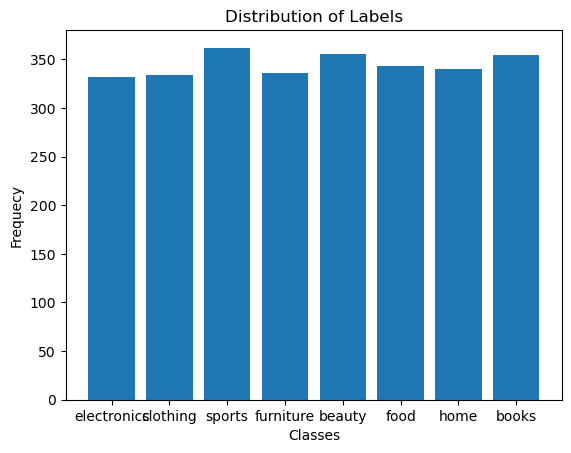

In [4]:
plt.bar(labels.keys(),labels.values())
plt.title('Distribution of Labels')
plt.xlabel('Classes')
plt.ylabel('Frequecy')
plt.show()

In [5]:
x_train, x_rest, y_train, y_rest = train_test_split(df.iloc[:,:10], y, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_rest, y_rest, test_size=0.5, random_state=42)
scalar = StandardScaler()
scalar.fit(x_train.values)
x_train = scalar.transform(x_train.values)
x_val = scalar.transform(x_val.values)
x_test = scalar.transform(x_test.values)

In [20]:
def Xent(y_true,y_pred):
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return np.sum(loss) / len(y_true)

def tanh(y):
    return (np.exp(y)-np.exp(-y)) / (np.exp(y)+np.exp(-y))

def relu(y):
    return np.where(y >= 0,y,0.0)

def sigmoid(y):
    return 1 / (1 + np.exp(-y))

class MLP:
    def __init__(self,input_size,output_size,num_layers,layer_sizes,activations,optimiser = 'batch',lr = 0.01):
        self.lr = lr
        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.layer_sizes = layer_sizes
        self.activations = activations
        self.optimiser = optimiser
#         Initialising weights and biases
        self.w_and_b = []
        prev_size = input_size
        for layer in range(num_layers):
            self.w_and_b.append(np.random.rand(layer_sizes[layer],prev_size+1))
            prev_size = layer_sizes[layer]
        self.w_and_b.append(np.random.rand(output_size,prev_size+1))
                            
        self.layer_inputs = []    
        self.layer_outputs = []
        self.out = np.zeros(output_size)
    
    def tanh_grad(self,z):
        return 1 - tanh(z)**2
    
    def relu_grad(self,z):
        return np.where(z > 0,1.0,0.0)
                            
    def sigmoid_grad(self,z):
        return sigmoid(z)*(1 - sigmoid(z))
    
    def XentGrad(self,y_true,y_pred):
        eps = 1e-10
        y = np.clip(y_pred, eps, 1 - eps)
        return - (y_true / (y_pred+eps) - (1 - y_true) / (1 - y_pred + eps)) / len(y_true)              
        
    def forward(self,x):
        inp = np.append(x,np.ones((x.shape[0],1)),axis=1)
        for layer in range(self.num_layers):    
            self.layer_inputs.append(inp) # (914,12)
            z = inp @ self.w_and_b[layer].T
            y = (self.activations[layer])(z)
            self.layer_outputs.append(z)
            inp = np.append(y,np.ones((y.shape[0],1)),axis=1)

        self.layer_inputs.append(inp) # (914,12)
        z = inp @ self.w_and_b[self.num_layers].T
        self.layer_outputs.append(z)
        y_prob = sigmoid(z) 
        self.out = y_prob
        return y_prob
    
    def backward(self,y_true):
        w_and_b_gradients = []
        grad_y_prob = self.XentGrad(y_true,self.out) # (batch,output)
        grad_y_linear = grad_y_prob*self.sigmoid_grad(self.layer_outputs[-1])  # (batch,output)
        grad_w_and_b = grad_y_linear.T @ self.layer_inputs[-1]
        w_and_b_gradients.append(grad_w_and_b)
        grad_y = grad_y_linear@self.w_and_b[-1][:,:-1]
        for layer in range(self.num_layers-1,-1,-1):
            grad_z = []
            if(self.activations[layer] == tanh):
                grad_z = grad_y*self.tanh_grad(self.layer_outputs[layer])
            elif(self.activations[layer] == relu):
                grad_z = grad_y*self.relu_grad(self.layer_outputs[layer])
            elif(self.activations[layer] == sigmoid):
                grad_z = grad_y*self.sigmoid_grad(self.layer_outputs[layer])
            
            grad_w_and_b = grad_z.T @ self.layer_inputs[layer] 
            w_and_b_gradients.append(grad_w_and_b)
            grad_y = grad_z@self.w_and_b[layer][:,:-1]
            
        for layer in range(self.num_layers,-1,-1):
            self.w_and_b[layer] -= self.lr*w_and_b_gradients[self.num_layers-layer]
    
    def training(self,x,y,epochs):
        num_samples = len(x)
        batch_size = 0
        if(self.optimiser == 'batch'):
            batch_size = x.shape[0]
        elif(self.optimiser == 'sgd'):
            batch_size = 1
        else:
            batch_size = 50
        for epoch in range(epochs):
            permutation = np.random.permutation(len(x))
            x_shuffled = x[permutation]
            y_shuffled = y[permutation]
            total_batches = math.ceil(num_samples / batch_size)
            for i in range(0,total_batches,batch_size):
                out = self.forward(x_shuffled[i:batch_size+i])
                self.backward(y_shuffled[i:batch_size+i])
                

        

In [7]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: khushi1703 (smai-khushi). Use `wandb login --relogin` to force relogin


True

In [8]:
input_size = x_train.shape[1]
output_size = y_train.shape[1]
num_layers = 1

In [9]:
def hamming_score(y_true,y_pred):
    hamming_distance = np.sum(np.abs(y_true - y_pred)) / len(y_true)
    hamming_score = 1 - np.mean(hamming_distance) / y_true.shape[1]
    return hamming_score

def f1_score_hamming(y_true,y_pred):
    x=np.array([])
    x2=np.array([])
    for i in range(len(y_true)):
        x = np.hstack((x,y_true[i]))
        x2 = np.hstack((x2,y_pred[i]))
    return f1_score(x,x2,average='macro',zero_division=0)
def precision_hamming(y_true,y_pred):
    x=np.array([])
    x2=np.array([])
    for i in range(len(y_true)):
        x = np.hstack((x,y_true[i]))
        x2 = np.hstack((x2,y_pred[i]))
    return precision_score(x,x2,average='macro',zero_division=0)
def recall_hamming(y_true,y_pred):
    x=np.array([])
    x2=np.array([])
    for i in range(len(y_true)):
        x = np.hstack((x,y_true[i]))
        x2 = np.hstack((x2,y_pred[i]))
    return recall_score(x,x2,average='macro',zero_division=0)

# input_size = x_train.shape[1]
# output_size = y_train.shape[1]
# num_layers = 1
# epoch = 2000
# classifier = MLP(input_size,output_size,num_layers,[8],[relu],'batch',0.01)
# #       Training
# classifier.training(x_train,y_train,epoch)
# #       Training metrics
# out = classifier.forward(x_train)
# predicted = np.where(out >= 0.5,1.0,0.0)
# hamming_train = hamming_score(y_train,predicted)
# loss_train = Xent(y_train,out)
# print("TRAINING")
# print(f"Epoch [{epoch}] Training => Accuracy : {hamming_train:.4f}")
# print(f"Epoch [{epoch}] Training => Loss : {loss_train:.4f}")


# #       Validation
# out = classifier.forward(x_val)
# predicted = np.where(out >= 0.5,1.0,0.0)
# hamming_test = hamming_score(y_val,predicted)
# loss_test = Xent(y_val,out)
# print("VALIDATION")
# print(f"Epoch [{epoch}] Validation => Accuracy : {hamming_test:.4f}")
# print(f"Epoch [{epoch}] Validation => Loss : {loss_test:.4f}")

In [13]:
lrs = [0.001,0.002,0.005,0.007]
epochs = [2000,3000,5000]
layer_sizes = [[8],[25],[64]]
activations =  [[tanh],[sigmoid],[relu]]
activation_names = ['tanh','sigmoid','relu']
optimiser = 'batch'

table = []
#  batch
for idx,activation in enumerate(activations):
    wandb.init(project = "Multilabel Classification Perceptron")
    for lr in lrs:
        for epoch in epochs:
            for size in layer_sizes:
                classifier = MLP(input_size,output_size,num_layers,size,activation,'batch',lr)
                size = size[0]
                #       Training
                classifier.training(x_train,y_train,epoch)
        #       Training metrics
                out = classifier.forward(x_train)
                predicted = np.where(out >= 0.5,1.0,0.0)
                hamming_train = hamming_score(y_train,predicted)
                loss_train = Xent(y_train,out)
                print("TRAINING")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Training => Hamming Accuracy : {hamming_train:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Training => Loss : {loss_train:.4f}")


        #       Validation
                out = classifier.forward(x_val)
                predicted = np.where(out >= 0.5,1.0,0.0)
                hamming_val = hamming_score(y_val,predicted)
                loss_val = Xent(y_val,out)
                f1 = f1_score_hamming(y_val,predicted)
                precision = precision_hamming(y_val,predicted)
                recall = recall_hamming(y_val,predicted)
                print("VALIDATION")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => hamming Accuracy : {hamming_val:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => f1 : {f1:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => precision : {precision:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => recall : {recall:.4f}")

                wandb.log({
                    "learning_rate": lr,
                    "epochs": epoch,
                    "layer_size": size,
                    "Validation accuracy": hamming_val,
                    "Training loss": loss_train,
                })
                entry = [lr,epoch,idx,size,hamming_val,f1,precision,recall]
                table.append(entry)
    wandb.finish()
                

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,▁
Validation accuracy,▁
epochs,▁
layer_size,▁
learning_rate,▁
Training loss,5.28713
Validation accuracy,0.48667
epochs,2000
layer_size,8
learning_rate,0.001


TRAINING
Epoch [2000], lr [0.001], activation [tanh], size [8] Training => Hamming Accuracy : 0.4916
Epoch [2000], lr [0.001], activation [tanh], size [8] Training => Loss : 5.3543
VALIDATION
Epoch [2000], lr [0.001], activation [tanh], size [8] Validation => hamming Accuracy : 0.4781
Epoch [2000], lr [0.001], activation [tanh], size [8] Validation => f1 : 0.4710
Epoch [2000], lr [0.001], activation [tanh], size [8] Validation => precision : 0.4970
Epoch [2000], lr [0.001], activation [tanh], size [8] Validation => recall : 0.4966
TRAINING
Epoch [2000], lr [0.001], activation [tanh], size [25] Training => Hamming Accuracy : 0.5306
Epoch [2000], lr [0.001], activation [tanh], size [25] Training => Loss : 5.1266
VALIDATION
Epoch [2000], lr [0.001], activation [tanh], size [25] Validation => hamming Accuracy : 0.5086
Epoch [2000], lr [0.001], activation [tanh], size [25] Validation => f1 : 0.4881
Epoch [2000], lr [0.001], activation [tanh], size [25] Validation => precision : 0.4988
Epoch

TRAINING
Epoch [5000], lr [0.002], activation [tanh], size [25] Training => Hamming Accuracy : 0.6506
Epoch [5000], lr [0.002], activation [tanh], size [25] Training => Loss : 4.5062
VALIDATION
Epoch [5000], lr [0.002], activation [tanh], size [25] Validation => hamming Accuracy : 0.6562
Epoch [5000], lr [0.002], activation [tanh], size [25] Validation => f1 : 0.4712
Epoch [5000], lr [0.002], activation [tanh], size [25] Validation => precision : 0.5414
Epoch [5000], lr [0.002], activation [tanh], size [25] Validation => recall : 0.5138
TRAINING
Epoch [5000], lr [0.002], activation [tanh], size [64] Training => Hamming Accuracy : 0.6424
Epoch [5000], lr [0.002], activation [tanh], size [64] Training => Loss : 4.5124
VALIDATION
Epoch [5000], lr [0.002], activation [tanh], size [64] Validation => hamming Accuracy : 0.6429
Epoch [5000], lr [0.002], activation [tanh], size [64] Validation => f1 : 0.5125
Epoch [5000], lr [0.002], activation [tanh], size [64] Validation => precision : 0.5466

TRAINING
Epoch [3000], lr [0.007], activation [tanh], size [64] Training => Hamming Accuracy : 0.6490
Epoch [3000], lr [0.007], activation [tanh], size [64] Training => Loss : 4.4382
VALIDATION
Epoch [3000], lr [0.007], activation [tanh], size [64] Validation => hamming Accuracy : 0.6438
Epoch [3000], lr [0.007], activation [tanh], size [64] Validation => f1 : 0.5022
Epoch [3000], lr [0.007], activation [tanh], size [64] Validation => precision : 0.5414
Epoch [3000], lr [0.007], activation [tanh], size [64] Validation => recall : 0.5224
TRAINING
Epoch [5000], lr [0.007], activation [tanh], size [8] Training => Hamming Accuracy : 0.6567
Epoch [5000], lr [0.007], activation [tanh], size [8] Training => Loss : 4.4392
VALIDATION
Epoch [5000], lr [0.007], activation [tanh], size [8] Validation => hamming Accuracy : 0.6790
Epoch [5000], lr [0.007], activation [tanh], size [8] Validation => f1 : 0.4662
Epoch [5000], lr [0.007], activation [tanh], size [8] Validation => precision : 0.6389
Epoc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,▄▄█▂▃▃▂▂▂▂▂▃▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy,▁▂▃▃▄▅▇▆▅▅▆▅▇▆▆▇▇▇▇▇▆▇▇▇█▇▇█▇▇██▇█▇▇
epochs,▁▁▁▃▃▃███▁▁▁▃▃▃███▁▁▁▃▃▃███▁▁▁▃▃▃███
layer_size,▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█
learning_rate,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▆▆▆▆▆▆▆▆▆█████████
Training loss,4.3741
Validation accuracy,0.65333
epochs,5000
layer_size,64
learning_rate,0.007


TRAINING
Epoch [2000], lr [0.001], activation [sigmoid], size [8] Training => Hamming Accuracy : 0.5231
Epoch [2000], lr [0.001], activation [sigmoid], size [8] Training => Loss : 5.0166
VALIDATION
Epoch [2000], lr [0.001], activation [sigmoid], size [8] Validation => hamming Accuracy : 0.5362
Epoch [2000], lr [0.001], activation [sigmoid], size [8] Validation => f1 : 0.5076
Epoch [2000], lr [0.001], activation [sigmoid], size [8] Validation => precision : 0.5126
Epoch [2000], lr [0.001], activation [sigmoid], size [8] Validation => recall : 0.5140
TRAINING
Epoch [2000], lr [0.001], activation [sigmoid], size [25] Training => Hamming Accuracy : 0.6147
Epoch [2000], lr [0.001], activation [sigmoid], size [25] Training => Loss : 4.6444
VALIDATION
Epoch [2000], lr [0.001], activation [sigmoid], size [25] Validation => hamming Accuracy : 0.6267
Epoch [2000], lr [0.001], activation [sigmoid], size [25] Validation => f1 : 0.4869
Epoch [2000], lr [0.001], activation [sigmoid], size [25] Valid

TRAINING
Epoch [5000], lr [0.002], activation [sigmoid], size [8] Training => Hamming Accuracy : 0.6504
Epoch [5000], lr [0.002], activation [sigmoid], size [8] Training => Loss : 4.5189
VALIDATION
Epoch [5000], lr [0.002], activation [sigmoid], size [8] Validation => hamming Accuracy : 0.6714
Epoch [5000], lr [0.002], activation [sigmoid], size [8] Validation => f1 : 0.4017
Epoch [5000], lr [0.002], activation [sigmoid], size [8] Validation => precision : 0.3357
Epoch [5000], lr [0.002], activation [sigmoid], size [8] Validation => recall : 0.5000
TRAINING
Epoch [5000], lr [0.002], activation [sigmoid], size [25] Training => Hamming Accuracy : 0.6500
Epoch [5000], lr [0.002], activation [sigmoid], size [25] Training => Loss : 4.5316
VALIDATION
Epoch [5000], lr [0.002], activation [sigmoid], size [25] Validation => hamming Accuracy : 0.6667
Epoch [5000], lr [0.002], activation [sigmoid], size [25] Validation => f1 : 0.4054
Epoch [5000], lr [0.002], activation [sigmoid], size [25] Valid

TRAINING
Epoch [3000], lr [0.007], activation [sigmoid], size [8] Training => Hamming Accuracy : 0.6510
Epoch [3000], lr [0.007], activation [sigmoid], size [8] Training => Loss : 4.5097
VALIDATION
Epoch [3000], lr [0.007], activation [sigmoid], size [8] Validation => hamming Accuracy : 0.6695
Epoch [3000], lr [0.007], activation [sigmoid], size [8] Validation => f1 : 0.4010
Epoch [3000], lr [0.007], activation [sigmoid], size [8] Validation => precision : 0.3354
Epoch [3000], lr [0.007], activation [sigmoid], size [8] Validation => recall : 0.4986
TRAINING
Epoch [3000], lr [0.007], activation [sigmoid], size [25] Training => Hamming Accuracy : 0.6496
Epoch [3000], lr [0.007], activation [sigmoid], size [25] Training => Loss : 4.4973
VALIDATION
Epoch [3000], lr [0.007], activation [sigmoid], size [25] Validation => hamming Accuracy : 0.6705
Epoch [3000], lr [0.007], activation [sigmoid], size [25] Validation => f1 : 0.4041
Epoch [3000], lr [0.007], activation [sigmoid], size [25] Valid

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,█▄▄▃▃▃▂▂▃▃▃▃▃▂▃▂▂▂▂▃▂▂▂▂▂▂▁▂▂▂▂▂▂▂▁▁
Validation accuracy,▁▅▆▇▇▆▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇█▇██
epochs,▁▁▁▃▃▃███▁▁▁▃▃▃███▁▁▁▃▃▃███▁▁▁▃▃▃███
layer_size,▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█
learning_rate,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▆▆▆▆▆▆▆▆▆█████████
Training loss,4.41342
Validation accuracy,0.68476
epochs,5000
layer_size,64
learning_rate,0.007


TRAINING
Epoch [2000], lr [0.001], activation [relu], size [8] Training => Hamming Accuracy : 0.5759
Epoch [2000], lr [0.001], activation [relu], size [8] Training => Loss : 4.7106
VALIDATION
Epoch [2000], lr [0.001], activation [relu], size [8] Validation => hamming Accuracy : 0.5990
Epoch [2000], lr [0.001], activation [relu], size [8] Validation => f1 : 0.5103
Epoch [2000], lr [0.001], activation [relu], size [8] Validation => precision : 0.5160
Epoch [2000], lr [0.001], activation [relu], size [8] Validation => recall : 0.5134
TRAINING
Epoch [2000], lr [0.001], activation [relu], size [25] Training => Hamming Accuracy : 0.6073
Epoch [2000], lr [0.001], activation [relu], size [25] Training => Loss : 4.8253
VALIDATION
Epoch [2000], lr [0.001], activation [relu], size [25] Validation => hamming Accuracy : 0.6305
Epoch [2000], lr [0.001], activation [relu], size [25] Validation => f1 : 0.5152
Epoch [2000], lr [0.001], activation [relu], size [25] Validation => precision : 0.5368
Epoch

TRAINING
Epoch [5000], lr [0.002], activation [relu], size [25] Training => Hamming Accuracy : 0.6478
Epoch [5000], lr [0.002], activation [relu], size [25] Training => Loss : 4.5080
VALIDATION
Epoch [5000], lr [0.002], activation [relu], size [25] Validation => hamming Accuracy : 0.6610
Epoch [5000], lr [0.002], activation [relu], size [25] Validation => f1 : 0.4899
Epoch [5000], lr [0.002], activation [relu], size [25] Validation => precision : 0.5632
Epoch [5000], lr [0.002], activation [relu], size [25] Validation => recall : 0.5240
TRAINING
Epoch [5000], lr [0.002], activation [relu], size [64] Training => Hamming Accuracy : 0.6222
Epoch [5000], lr [0.002], activation [relu], size [64] Training => Loss : 4.8520
VALIDATION
Epoch [5000], lr [0.002], activation [relu], size [64] Validation => hamming Accuracy : 0.6390
Epoch [5000], lr [0.002], activation [relu], size [64] Validation => f1 : 0.4813
Epoch [5000], lr [0.002], activation [relu], size [64] Validation => precision : 0.5207

TRAINING
Epoch [3000], lr [0.007], activation [relu], size [64] Training => Hamming Accuracy : 0.6500
Epoch [3000], lr [0.007], activation [relu], size [64] Training => Loss : 4.4862
VALIDATION
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => hamming Accuracy : 0.6514
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => f1 : 0.4454
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => precision : 0.5053
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => recall : 0.5014
TRAINING
Epoch [5000], lr [0.007], activation [relu], size [8] Training => Hamming Accuracy : 0.6504
Epoch [5000], lr [0.007], activation [relu], size [8] Training => Loss : 4.4753
VALIDATION
Epoch [5000], lr [0.007], activation [relu], size [8] Validation => hamming Accuracy : 0.6705
Epoch [5000], lr [0.007], activation [relu], size [8] Validation => f1 : 0.4069
Epoch [5000], lr [0.007], activation [relu], size [8] Validation => precision : 0.5359
Epoc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,▁▁█▁▂▂▁▁▂▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy,▅▆▁▄▄▆▆▆▆▅▆▇█▅▆█▇▆██▆██▇████▇▇██▇███
epochs,▁▁▁▃▃▃███▁▁▁▃▃▃███▁▁▁▃▃▃███▁▁▁▃▃▃███
layer_size,▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█
learning_rate,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▆▆▆▆▆▆▆▆▆█████████
Training loss,4.40641
Validation accuracy,0.66667
epochs,5000
layer_size,64
learning_rate,0.007


In [14]:
table_batch = table

In [15]:
table = pd.DataFrame(table_batch,columns = ['LR','Epochs','Activation','layer size','Hamming','F1','Precision','Recall'])
table

,LR,Epochs,Activation,layer size,Hamming,F1,Precision,Recall
0,0.001,2000,0,8,0.478095,0.470953,0.496997,0.496639
1,0.001,2000,0,25,0.508571,0.488095,0.498771,0.498612
2,0.001,2000,0,64,0.549524,0.519857,0.523637,0.526149
3,0.001,3000,0,8,0.539048,0.491851,0.492823,0.492445
4,0.001,3000,0,25,0.562857,0.502021,0.502057,0.502035
...,...,...,...,...,...,...,...,...
103,0.007,3000,2,25,0.669524,0.450395,0.576885,0.513383
104,0.007,3000,2,64,0.651429,0.445375,0.505271,0.501388
105,0.007,5000,2,8,0.670476,0.406857,0.535885,0.500771
106,0.007,5000,2,25,0.667619,0.451602,0.566906,0.512704


In [16]:
print("Batch tanh Metrics")
df_batch_tanh = table[table['Activation'] == 0].drop('Activation',axis = 1)
df_batch_tanh = df_batch_tanh.sort_values(by='Hamming', ascending=False)
df_batch_tanh

Batch tanh Metrics


,LR,Epochs,layer size,Hamming,F1,Precision,Recall
27,0.007,2000,8,0.683810,0.455398,0.720976,0.523281
33,0.007,5000,8,0.679048,0.466234,0.638889,0.524175
30,0.007,3000,8,0.675238,0.424589,0.671002,0.508757
31,0.007,3000,25,0.669524,0.488183,0.586018,0.527444
24,0.005,5000,8,0.669524,0.414465,0.544557,0.502282
34,0.007,5000,25,0.668571,0.468713,0.577948,0.519334
26,0.005,5000,64,0.665714,0.523942,0.585042,0.542368
21,0.005,3000,8,0.665714,0.410338,0.478282,0.498705
25,0.005,5000,25,0.664762,0.470490,0.564597,0.517977
18,0.005,2000,8,0.661905,0.428525,0.512593,0.501788


In [17]:
print("Batch sigmoid Metrics")
df_batch_sigmoid = table[table['Activation'] == 1].drop('Activation',axis = 1)
df_batch_sigmoid = df_batch_sigmoid.sort_values(by='Hamming', ascending=False)
df_batch_sigmoid

Batch sigmoid Metrics


,LR,Epochs,layer size,Hamming,F1,Precision,Recall
71,0.007,5000,64,0.684762,0.473628,0.680074,0.529911
68,0.007,3000,64,0.677143,0.437922,0.663835,0.513876
43,0.001,5000,25,0.677143,0.430497,0.695463,0.511656
70,0.007,5000,25,0.675238,0.422011,0.687500,0.508017
61,0.005,5000,25,0.674286,0.411018,0.836676,0.504348
55,0.005,2000,25,0.672381,0.410286,0.636364,0.502929
51,0.002,5000,8,0.671429,0.401709,0.335714,0.500000
69,0.007,5000,8,0.671429,0.401709,0.335714,0.500000
63,0.007,2000,8,0.671429,0.401709,0.335714,0.500000
60,0.005,5000,8,0.671429,0.401709,0.335714,0.500000


In [18]:
print("Batch relu Metrics")
df_batch_relu = table[table['Activation'] == 2].drop('Activation',axis = 1)
df_batch_relu = df_batch_relu.sort_values(by='Hamming', ascending=False)
df_batch_relu

Batch relu Metrics


,LR,Epochs,layer size,Hamming,F1,Precision,Recall
91,0.005,2000,25,0.675238,0.474460,0.609406,0.525039
97,0.005,5000,25,0.672381,0.451850,0.595678,0.515510
102,0.007,3000,8,0.671429,0.401709,0.335714,0.500000
93,0.005,3000,8,0.671429,0.422966,0.587041,0.505920
105,0.007,5000,8,0.670476,0.406857,0.535885,0.500771
103,0.007,3000,25,0.669524,0.450395,0.576885,0.513383
99,0.007,2000,8,0.669524,0.409185,0.523393,0.500802
96,0.005,5000,8,0.668571,0.411465,0.517718,0.500833
106,0.007,5000,25,0.667619,0.451602,0.566906,0.512704
107,0.007,5000,64,0.666667,0.457481,0.565432,0.514215


In [21]:
lrs = [0.001,0.002,0.005,0.007]
epochs = [2000,3000,5000]
layer_sizes = [[8],[25],[64]]
activations =  [[tanh],[sigmoid],[relu]]
activation_names = ['tanh','sigmoid','relu']

table = []
#  minibatch
for idx,activation in enumerate(activations):
    wandb.init(project = "Multilabel Classification Perceptron")
    for lr in lrs:
        for epoch in epochs:
            for size in layer_sizes:
                classifier = MLP(input_size,output_size,num_layers,size,activation,'minibatch',lr)
                size = size[0]
                #       Training
                classifier.training(x_train,y_train,epoch)
        #       Training metrics
                out = classifier.forward(x_train)
                predicted = np.where(out >= 0.5,1.0,0.0)
                hamming_train = hamming_score(y_train,predicted)
                loss_train = Xent(y_train,out)
                print("TRAINING")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Training => Hamming Accuracy : {hamming_train:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Training => Loss : {loss_train:.4f}")


        #       Validation
                out = classifier.forward(x_val)
                predicted = np.where(out >= 0.5,1.0,0.0)
                hamming_val = hamming_score(y_val,predicted)
                loss_val = Xent(y_val,out)
                f1 = f1_score_hamming(y_val,predicted)
                precision = precision_hamming(y_val,predicted)
                recall = recall_hamming(y_val,predicted)
                print("VALIDATION")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => hamming Accuracy : {hamming_val:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => f1 : {f1:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => precision : {precision:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => recall : {recall:.4f}")

                wandb.log({
                    "learning_rate": lr,
                    "epochs": epoch,
                    "layer_size": size,
                    "Validation accuracy": hamming_val,
                    "Training loss": loss_train,
                })
                entry = [lr,epoch,idx,size,hamming_val,f1,precision,recall]
                table.append(entry)
    wandb.finish()
                

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


TRAINING
Epoch [2000], lr [0.001], activation [tanh], size [8] Training => Hamming Accuracy : 0.5090
Epoch [2000], lr [0.001], activation [tanh], size [8] Training => Loss : 5.4305
VALIDATION
Epoch [2000], lr [0.001], activation [tanh], size [8] Validation => hamming Accuracy : 0.5171
Epoch [2000], lr [0.001], activation [tanh], size [8] Validation => f1 : 0.4972
Epoch [2000], lr [0.001], activation [tanh], size [8] Validation => precision : 0.5077
Epoch [2000], lr [0.001], activation [tanh], size [8] Validation => recall : 0.5087
TRAINING
Epoch [2000], lr [0.001], activation [tanh], size [25] Training => Hamming Accuracy : 0.5251
Epoch [2000], lr [0.001], activation [tanh], size [25] Training => Loss : 5.3918
VALIDATION
Epoch [2000], lr [0.001], activation [tanh], size [25] Validation => hamming Accuracy : 0.5057
Epoch [2000], lr [0.001], activation [tanh], size [25] Validation => f1 : 0.4906
Epoch [2000], lr [0.001], activation [tanh], size [25] Validation => precision : 0.5054
Epoch

TRAINING
Epoch [5000], lr [0.002], activation [tanh], size [25] Training => Hamming Accuracy : 0.6359
Epoch [5000], lr [0.002], activation [tanh], size [25] Training => Loss : 4.5169
VALIDATION
Epoch [5000], lr [0.002], activation [tanh], size [25] Validation => hamming Accuracy : 0.6371
Epoch [5000], lr [0.002], activation [tanh], size [25] Validation => f1 : 0.4848
Epoch [5000], lr [0.002], activation [tanh], size [25] Validation => precision : 0.5213
Epoch [5000], lr [0.002], activation [tanh], size [25] Validation => recall : 0.5107
TRAINING
Epoch [5000], lr [0.002], activation [tanh], size [64] Training => Hamming Accuracy : 0.6418
Epoch [5000], lr [0.002], activation [tanh], size [64] Training => Loss : 4.5379
VALIDATION
Epoch [5000], lr [0.002], activation [tanh], size [64] Validation => hamming Accuracy : 0.6343
Epoch [5000], lr [0.002], activation [tanh], size [64] Validation => f1 : 0.4946
Epoch [5000], lr [0.002], activation [tanh], size [64] Validation => precision : 0.5257

TRAINING
Epoch [3000], lr [0.007], activation [tanh], size [64] Training => Hamming Accuracy : 0.6508
Epoch [3000], lr [0.007], activation [tanh], size [64] Training => Loss : 4.4403
VALIDATION
Epoch [3000], lr [0.007], activation [tanh], size [64] Validation => hamming Accuracy : 0.6419
Epoch [3000], lr [0.007], activation [tanh], size [64] Validation => f1 : 0.5231
Epoch [3000], lr [0.007], activation [tanh], size [64] Validation => precision : 0.5518
Epoch [3000], lr [0.007], activation [tanh], size [64] Validation => recall : 0.5335
TRAINING
Epoch [5000], lr [0.007], activation [tanh], size [8] Training => Hamming Accuracy : 0.6533
Epoch [5000], lr [0.007], activation [tanh], size [8] Training => Loss : 4.4468
VALIDATION
Epoch [5000], lr [0.007], activation [tanh], size [8] Validation => hamming Accuracy : 0.6676
Epoch [5000], lr [0.007], activation [tanh], size [8] Validation => f1 : 0.4238
Epoch [5000], lr [0.007], activation [tanh], size [8] Validation => precision : 0.5411
Epoc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,▅▅█▂▂▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy,▁▁▂▅▄▄▇▅▆▅▄▄▇▇▅▇▆▆▇█▆▇▇▆██▆█▇▆██▇██▇
epochs,▁▁▁▃▃▃███▁▁▁▃▃▃███▁▁▁▃▃▃███▁▁▁▃▃▃███
layer_size,▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█
learning_rate,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▆▆▆▆▆▆▆▆▆█████████
Training loss,4.36873
Validation accuracy,0.65619
epochs,5000
layer_size,64
learning_rate,0.007


TRAINING
Epoch [2000], lr [0.001], activation [sigmoid], size [8] Training => Hamming Accuracy : 0.5316
Epoch [2000], lr [0.001], activation [sigmoid], size [8] Training => Loss : 4.8749
VALIDATION
Epoch [2000], lr [0.001], activation [sigmoid], size [8] Validation => hamming Accuracy : 0.5162
Epoch [2000], lr [0.001], activation [sigmoid], size [8] Validation => f1 : 0.4803
Epoch [2000], lr [0.001], activation [sigmoid], size [8] Validation => precision : 0.4843
Epoch [2000], lr [0.001], activation [sigmoid], size [8] Validation => recall : 0.4828
TRAINING
Epoch [2000], lr [0.001], activation [sigmoid], size [25] Training => Hamming Accuracy : 0.5612
Epoch [2000], lr [0.001], activation [sigmoid], size [25] Training => Loss : 4.7909
VALIDATION
Epoch [2000], lr [0.001], activation [sigmoid], size [25] Validation => hamming Accuracy : 0.5476
Epoch [2000], lr [0.001], activation [sigmoid], size [25] Validation => f1 : 0.4739
Epoch [2000], lr [0.001], activation [sigmoid], size [25] Valid

TRAINING
Epoch [5000], lr [0.002], activation [sigmoid], size [8] Training => Hamming Accuracy : 0.6504
Epoch [5000], lr [0.002], activation [sigmoid], size [8] Training => Loss : 4.5330
VALIDATION
Epoch [5000], lr [0.002], activation [sigmoid], size [8] Validation => hamming Accuracy : 0.6714
Epoch [5000], lr [0.002], activation [sigmoid], size [8] Validation => f1 : 0.4017
Epoch [5000], lr [0.002], activation [sigmoid], size [8] Validation => precision : 0.3357
Epoch [5000], lr [0.002], activation [sigmoid], size [8] Validation => recall : 0.5000
TRAINING
Epoch [5000], lr [0.002], activation [sigmoid], size [25] Training => Hamming Accuracy : 0.6494
Epoch [5000], lr [0.002], activation [sigmoid], size [25] Training => Loss : 4.5315
VALIDATION
Epoch [5000], lr [0.002], activation [sigmoid], size [25] Validation => hamming Accuracy : 0.6686
Epoch [5000], lr [0.002], activation [sigmoid], size [25] Validation => f1 : 0.4061
Epoch [5000], lr [0.002], activation [sigmoid], size [25] Valid

TRAINING
Epoch [3000], lr [0.007], activation [sigmoid], size [8] Training => Hamming Accuracy : 0.6502
Epoch [3000], lr [0.007], activation [sigmoid], size [8] Training => Loss : 4.5065
VALIDATION
Epoch [3000], lr [0.007], activation [sigmoid], size [8] Validation => hamming Accuracy : 0.6714
Epoch [3000], lr [0.007], activation [sigmoid], size [8] Validation => f1 : 0.4017
Epoch [3000], lr [0.007], activation [sigmoid], size [8] Validation => precision : 0.3357
Epoch [3000], lr [0.007], activation [sigmoid], size [8] Validation => recall : 0.5000
TRAINING
Epoch [3000], lr [0.007], activation [sigmoid], size [25] Training => Hamming Accuracy : 0.6506
Epoch [3000], lr [0.007], activation [sigmoid], size [25] Training => Loss : 4.4785
VALIDATION
Epoch [3000], lr [0.007], activation [sigmoid], size [25] Validation => hamming Accuracy : 0.6724
Epoch [3000], lr [0.007], activation [sigmoid], size [25] Validation => f1 : 0.4103
Epoch [3000], lr [0.007], activation [sigmoid], size [25] Valid

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,█▇▅▄▃▄▃▃▄▃▃▃▃▃▄▃▃▃▃▃▃▃▂▂▃▂▁▂▃▂▂▂▂▃▂▁
Validation accuracy,▁▂▆█▇▇█████▇██▇█████████████████████
epochs,▁▁▁▃▃▃███▁▁▁▃▃▃███▁▁▁▃▃▃███▁▁▁▃▃▃███
layer_size,▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█
learning_rate,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▆▆▆▆▆▆▆▆▆█████████
Training loss,4.40824
Validation accuracy,0.66857
epochs,5000
layer_size,64
learning_rate,0.007


TRAINING
Epoch [2000], lr [0.001], activation [relu], size [8] Training => Hamming Accuracy : 0.6029
Epoch [2000], lr [0.001], activation [relu], size [8] Training => Loss : 4.7453
VALIDATION
Epoch [2000], lr [0.001], activation [relu], size [8] Validation => hamming Accuracy : 0.6257
Epoch [2000], lr [0.001], activation [relu], size [8] Validation => f1 : 0.5059
Epoch [2000], lr [0.001], activation [relu], size [8] Validation => precision : 0.5267
Epoch [2000], lr [0.001], activation [relu], size [8] Validation => recall : 0.5178
TRAINING
Epoch [2000], lr [0.001], activation [relu], size [25] Training => Hamming Accuracy : 0.5767
Epoch [2000], lr [0.001], activation [relu], size [25] Training => Loss : 5.0857
VALIDATION
Epoch [2000], lr [0.001], activation [relu], size [25] Validation => hamming Accuracy : 0.5714
Epoch [2000], lr [0.001], activation [relu], size [25] Validation => f1 : 0.5076
Epoch [2000], lr [0.001], activation [relu], size [25] Validation => precision : 0.5079
Epoch

TRAINING
Epoch [5000], lr [0.002], activation [relu], size [25] Training => Hamming Accuracy : 0.6357
Epoch [5000], lr [0.002], activation [relu], size [25] Training => Loss : 4.6075
VALIDATION
Epoch [5000], lr [0.002], activation [relu], size [25] Validation => hamming Accuracy : 0.6333
Epoch [5000], lr [0.002], activation [relu], size [25] Validation => f1 : 0.4650
Epoch [5000], lr [0.002], activation [relu], size [25] Validation => precision : 0.4994
Epoch [5000], lr [0.002], activation [relu], size [25] Validation => recall : 0.4998
TRAINING
Epoch [5000], lr [0.002], activation [relu], size [64] Training => Hamming Accuracy : 0.6463
Epoch [5000], lr [0.002], activation [relu], size [64] Training => Loss : 4.6916
VALIDATION
Epoch [5000], lr [0.002], activation [relu], size [64] Validation => hamming Accuracy : 0.6629
Epoch [5000], lr [0.002], activation [relu], size [64] Validation => f1 : 0.4513
Epoch [5000], lr [0.002], activation [relu], size [64] Validation => precision : 0.5456

TRAINING
Epoch [3000], lr [0.007], activation [relu], size [64] Training => Hamming Accuracy : 0.6473
Epoch [3000], lr [0.007], activation [relu], size [64] Training => Loss : 4.5451
VALIDATION
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => hamming Accuracy : 0.6514
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => f1 : 0.4592
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => precision : 0.5208
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => recall : 0.5066
TRAINING
Epoch [5000], lr [0.007], activation [relu], size [8] Training => Hamming Accuracy : 0.6516
Epoch [5000], lr [0.007], activation [relu], size [8] Training => Loss : 4.4597
VALIDATION
Epoch [5000], lr [0.007], activation [relu], size [8] Validation => hamming Accuracy : 0.6686
Epoch [5000], lr [0.007], activation [relu], size [8] Validation => f1 : 0.4217
Epoch [5000], lr [0.007], activation [relu], size [8] Validation => precision : 0.5471
Epoc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,▂▂█▁▂▇▁▂▂▁▁▄▁▂▃▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation accuracy,▆▄▁▆▅▅▆▅▆█▅▆█▇▆▇▇██████▇█████▇██▇██▇
epochs,▁▁▁▃▃▃███▁▁▁▃▃▃███▁▁▁▃▃▃███▁▁▁▃▃▃███
layer_size,▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█
learning_rate,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▆▆▆▆▆▆▆▆▆█████████
Training loss,4.43995
Validation accuracy,0.65238
epochs,5000
layer_size,64
learning_rate,0.007


In [22]:
table_minibatch = table

In [23]:
table = pd.DataFrame(table_minibatch,columns = ['LR','Epochs','Activation','layer size','Hamming','F1','Precision','Recall'])
table

,LR,Epochs,Activation,layer size,Hamming,F1,Precision,Recall
0,0.001,2000,0,8,0.517143,0.497223,0.507697,0.508696
1,0.001,2000,0,25,0.505714,0.490577,0.505388,0.506105
2,0.001,2000,0,64,0.527619,0.492558,0.496143,0.495776
3,0.001,3000,0,8,0.599048,0.492561,0.501135,0.500863
4,0.001,3000,0,25,0.584762,0.507447,0.509651,0.508726
...,...,...,...,...,...,...,...,...
103,0.007,3000,2,25,0.662857,0.433622,0.525813,0.503978
104,0.007,3000,2,64,0.651429,0.459208,0.520825,0.506568
105,0.007,5000,2,8,0.668571,0.421748,0.547093,0.503793
106,0.007,5000,2,25,0.663810,0.436369,0.534325,0.505427


In [24]:
print("MiniBatch tanh Metrics")
df_minibatch_tanh = table[table['Activation'] == 0].drop('Activation',axis = 1)
df_minibatch_tanh = df_minibatch_tanh.sort_values(by='Hamming', ascending=False)
df_minibatch_tanh

MiniBatch tanh Metrics


,LR,Epochs,layer size,Hamming,F1,Precision,Recall
27,0.007,2000,8,0.674286,0.426724,0.637681,0.508788
25,0.005,5000,25,0.674286,0.492880,0.603009,0.531730
30,0.007,3000,8,0.673333,0.413340,0.670019,0.504379
24,0.005,5000,8,0.673333,0.423778,0.623069,0.507339
31,0.007,3000,25,0.671429,0.478161,0.591463,0.524422
33,0.007,5000,8,0.667619,0.423831,0.541121,0.503824
19,0.005,2000,25,0.667619,0.481580,0.578218,0.523805
34,0.007,5000,25,0.666667,0.481017,0.574979,0.523096
12,0.002,3000,8,0.660000,0.477094,0.554348,0.518131
15,0.002,5000,8,0.660000,0.405501,0.417636,0.493710


In [25]:
print("MiniBatch sigmoid Metrics")
df_minibatch_sigmoid = table[table['Activation'] == 1].drop('Activation',axis = 1)
df_minibatch_sigmoid = df_minibatch_sigmoid.sort_values(by='Hamming', ascending=False)
df_minibatch_sigmoid

MiniBatch sigmoid Metrics


,LR,Epochs,layer size,Hamming,F1,Precision,Recall
68,0.007,3000,64,0.677143,0.449739,0.639706,0.517576
64,0.007,2000,25,0.674286,0.411018,0.836676,0.504348
56,0.005,2000,64,0.673333,0.428815,0.615472,0.508819
59,0.005,3000,64,0.672381,0.435713,0.598049,0.510330
53,0.002,5000,64,0.672381,0.420816,0.606261,0.505890
67,0.007,3000,25,0.672381,0.410286,0.636364,0.502929
61,0.005,5000,25,0.672381,0.412965,0.622244,0.503669
54,0.005,2000,8,0.671429,0.401709,0.335714,0.500000
49,0.002,3000,25,0.671429,0.401709,0.335714,0.500000
60,0.005,5000,8,0.671429,0.401709,0.335714,0.500000


In [26]:
print("MiniBatch relu Metrics")
df_minibatch_relu = table[table['Activation'] == 2].drop('Activation',axis = 1)
df_minibatch_relu = df_minibatch_relu.sort_values(by='Hamming', ascending=False)
df_minibatch_relu

MiniBatch relu Metrics


,LR,Epochs,layer size,Hamming,F1,Precision,Recall
96,0.005,5000,8,0.670476,0.406857,0.535885,0.500771
93,0.005,3000,8,0.669524,0.406498,0.502395,0.500062
105,0.007,5000,8,0.668571,0.421748,0.547093,0.503793
90,0.005,2000,8,0.665714,0.418025,0.510922,0.500925
91,0.005,2000,25,0.665714,0.463127,0.564394,0.515726
102,0.007,3000,8,0.665714,0.410338,0.478282,0.498705
99,0.007,2000,8,0.665714,0.427869,0.533023,0.503885
84,0.002,3000,8,0.664762,0.417626,0.502430,0.500216
106,0.007,5000,25,0.663810,0.436369,0.534325,0.505427
89,0.002,5000,64,0.662857,0.451281,0.545561,0.509898


In [27]:
lrs = [0.001,0.002,0.005,0.007]
epochs = [2000,3000,5000]
layer_sizes = [[8],[25],[64]]
activations =  [[tanh],[sigmoid],[relu]]
activation_names = ['tanh','sigmoid','relu']

table = []
#  sgd
for idx,activation in enumerate(activations):
    wandb.init(project = "Multilabel Classification Perceptron")
    for lr in lrs:
        for epoch in epochs:
            for size in layer_sizes:
                classifier = MLP(input_size,output_size,num_layers,size,activation,'sgd',lr)
                size = size[0]
                #       Training
                classifier.training(x_train,y_train,epoch)
        #       Training metrics
                out = classifier.forward(x_train)
                predicted = np.where(out >= 0.5,1.0,0.0)
                hamming_train = hamming_score(y_train,predicted)
                loss_train = Xent(y_train,out)
                print("TRAINING")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Training => Hamming Accuracy : {hamming_train:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Training => Loss : {loss_train:.4f}")


        #       Validation
                out = classifier.forward(x_val)
                predicted = np.where(out >= 0.5,1.0,0.0)
                hamming_val = hamming_score(y_val,predicted)
                loss_val = Xent(y_val,out)
                f1 = f1_score_hamming(y_val,predicted)
                precision = precision_hamming(y_val,predicted)
                recall = recall_hamming(y_val,predicted)
                print("VALIDATION")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => hamming Accuracy : {hamming_val:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => f1 : {f1:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => precision : {precision:.4f}")
                print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => recall : {recall:.4f}")

                wandb.log({
                    "learning_rate": lr,
                    "epochs": epoch,
                    "layer_size": size,
                    "Validation accuracy": hamming_val,
                    "Training loss": loss_train,
                })
                entry = [lr,epoch,idx,size,hamming_val,f1,precision,recall]
                table.append(entry)
    wandb.finish()
                

TRAINING
Epoch [2000], lr [0.001], activation [tanh], size [8] Training => Hamming Accuracy : 0.6510
Epoch [2000], lr [0.001], activation [tanh], size [8] Training => Loss : 4.4422
VALIDATION
Epoch [2000], lr [0.001], activation [tanh], size [8] Validation => hamming Accuracy : 0.6686
Epoch [2000], lr [0.001], activation [tanh], size [8] Validation => f1 : 0.4455
Epoch [2000], lr [0.001], activation [tanh], size [8] Validation => precision : 0.5690
Epoch [2000], lr [0.001], activation [tanh], size [8] Validation => recall : 0.5112
TRAINING
Epoch [2000], lr [0.001], activation [tanh], size [25] Training => Hamming Accuracy : 0.6702
Epoch [2000], lr [0.001], activation [tanh], size [25] Training => Loss : 4.2930
VALIDATION
Epoch [2000], lr [0.001], activation [tanh], size [25] Validation => hamming Accuracy : 0.6333
Epoch [2000], lr [0.001], activation [tanh], size [25] Validation => f1 : 0.4854
Epoch [2000], lr [0.001], activation [tanh], size [25] Validation => precision : 0.5177
Epoch

TRAINING
Epoch [5000], lr [0.002], activation [tanh], size [25] Training => Hamming Accuracy : 0.6633
Epoch [5000], lr [0.002], activation [tanh], size [25] Training => Loss : 4.3327
VALIDATION
Epoch [5000], lr [0.002], activation [tanh], size [25] Validation => hamming Accuracy : 0.6619
Epoch [5000], lr [0.002], activation [tanh], size [25] Validation => f1 : 0.4988
Epoch [5000], lr [0.002], activation [tanh], size [25] Validation => precision : 0.5691
Epoch [5000], lr [0.002], activation [tanh], size [25] Validation => recall : 0.5284
TRAINING
Epoch [5000], lr [0.002], activation [tanh], size [64] Training => Hamming Accuracy : 0.6929
Epoch [5000], lr [0.002], activation [tanh], size [64] Training => Loss : 4.0955
VALIDATION
Epoch [5000], lr [0.002], activation [tanh], size [64] Validation => hamming Accuracy : 0.6238
Epoch [5000], lr [0.002], activation [tanh], size [64] Validation => f1 : 0.5071
Epoch [5000], lr [0.002], activation [tanh], size [64] Validation => precision : 0.5261

TRAINING
Epoch [3000], lr [0.007], activation [tanh], size [64] Training => Hamming Accuracy : 0.6702
Epoch [3000], lr [0.007], activation [tanh], size [64] Training => Loss : 4.2713
VALIDATION
Epoch [3000], lr [0.007], activation [tanh], size [64] Validation => hamming Accuracy : 0.6190
Epoch [3000], lr [0.007], activation [tanh], size [64] Validation => f1 : 0.5315
Epoch [3000], lr [0.007], activation [tanh], size [64] Validation => precision : 0.5407
Epoch [3000], lr [0.007], activation [tanh], size [64] Validation => recall : 0.5335
TRAINING
Epoch [5000], lr [0.007], activation [tanh], size [8] Training => Hamming Accuracy : 0.6516
Epoch [5000], lr [0.007], activation [tanh], size [8] Training => Loss : 4.4513
VALIDATION
Epoch [5000], lr [0.007], activation [tanh], size [8] Validation => hamming Accuracy : 0.6695
Epoch [5000], lr [0.007], activation [tanh], size [8] Validation => f1 : 0.4247
Epoch [5000], lr [0.007], activation [tanh], size [8] Validation => precision : 0.5619
Epoc

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,█▅▂▇▆▁█▆▂▇▆▃▇▆▁█▆▁█▆▂█▆▂█▅▂█▆▃█▆▅█▆▂
Validation accuracy,▇▄▃▇▆▅█▇▄█▆▆█▇▃█▇▄▇▆▃▇▅▂▆▇▄▇▆▃█▅▃▇▄▁
epochs,▁▁▁▃▃▃███▁▁▁▃▃▃███▁▁▁▃▃▃███▁▁▁▃▃▃███
layer_size,▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█
learning_rate,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▆▆▆▆▆▆▆▆▆█████████
Training loss,4.1067
Validation accuracy,0.58857
epochs,5000
layer_size,64
learning_rate,0.007


TRAINING
Epoch [2000], lr [0.001], activation [sigmoid], size [8] Training => Hamming Accuracy : 0.6537
Epoch [2000], lr [0.001], activation [sigmoid], size [8] Training => Loss : 4.4475
VALIDATION
Epoch [2000], lr [0.001], activation [sigmoid], size [8] Validation => hamming Accuracy : 0.6686
Epoch [2000], lr [0.001], activation [sigmoid], size [8] Validation => f1 : 0.4267
Epoch [2000], lr [0.001], activation [sigmoid], size [8] Validation => precision : 0.5543
Epoch [2000], lr [0.001], activation [sigmoid], size [8] Validation => recall : 0.5053
TRAINING
Epoch [2000], lr [0.001], activation [sigmoid], size [25] Training => Hamming Accuracy : 0.6627
Epoch [2000], lr [0.001], activation [sigmoid], size [25] Training => Loss : 4.3446
VALIDATION
Epoch [2000], lr [0.001], activation [sigmoid], size [25] Validation => hamming Accuracy : 0.6724
Epoch [2000], lr [0.001], activation [sigmoid], size [25] Validation => f1 : 0.4987
Epoch [2000], lr [0.001], activation [sigmoid], size [25] Valid

TRAINING
Epoch [5000], lr [0.002], activation [sigmoid], size [8] Training => Hamming Accuracy : 0.6533
Epoch [5000], lr [0.002], activation [sigmoid], size [8] Training => Loss : 4.4428
VALIDATION
Epoch [5000], lr [0.002], activation [sigmoid], size [8] Validation => hamming Accuracy : 0.6695
Epoch [5000], lr [0.002], activation [sigmoid], size [8] Validation => f1 : 0.4344
Epoch [5000], lr [0.002], activation [sigmoid], size [8] Validation => precision : 0.5697
Epoch [5000], lr [0.002], activation [sigmoid], size [8] Validation => recall : 0.5082
TRAINING
Epoch [5000], lr [0.002], activation [sigmoid], size [25] Training => Hamming Accuracy : 0.6637
Epoch [5000], lr [0.002], activation [sigmoid], size [25] Training => Loss : 4.3530
VALIDATION
Epoch [5000], lr [0.002], activation [sigmoid], size [25] Validation => hamming Accuracy : 0.6600
Epoch [5000], lr [0.002], activation [sigmoid], size [25] Validation => f1 : 0.4842
Epoch [5000], lr [0.002], activation [sigmoid], size [25] Valid

TRAINING
Epoch [3000], lr [0.007], activation [sigmoid], size [8] Training => Hamming Accuracy : 0.6498
Epoch [3000], lr [0.007], activation [sigmoid], size [8] Training => Loss : 4.4944
VALIDATION
Epoch [3000], lr [0.007], activation [sigmoid], size [8] Validation => hamming Accuracy : 0.6667
Epoch [3000], lr [0.007], activation [sigmoid], size [8] Validation => f1 : 0.4159
Epoch [3000], lr [0.007], activation [sigmoid], size [8] Validation => precision : 0.5124
Epoch [3000], lr [0.007], activation [sigmoid], size [8] Validation => recall : 0.5009
TRAINING
Epoch [3000], lr [0.007], activation [sigmoid], size [25] Training => Hamming Accuracy : 0.6571
Epoch [3000], lr [0.007], activation [sigmoid], size [25] Training => Loss : 4.4243
VALIDATION
Epoch [3000], lr [0.007], activation [sigmoid], size [25] Validation => hamming Accuracy : 0.6552
Epoch [3000], lr [0.007], activation [sigmoid], size [25] Validation => f1 : 0.4796
Epoch [3000], lr [0.007], activation [sigmoid], size [25] Valid

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,▇▅▄▇▅▃▇▅▃▇▆▄▇▅▃▇▅▂█▅▃▇▆▅█▆▆█▇▅█▇▅██▁
Validation accuracy,▇▇▆█▆▇▇▇▇█▇▆▇▇▄▇▆▄▇▇▄▆▆▆▇▆▅▇▆▄▇▆▁▇▅▃
epochs,▁▁▁▃▃▃███▁▁▁▃▃▃███▁▁▁▃▃▃███▁▁▁▃▃▃███
layer_size,▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█
learning_rate,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▆▆▆▆▆▆▆▆▆█████████
Training loss,4.11565
Validation accuracy,0.62857
epochs,5000
layer_size,64
learning_rate,0.007


TRAINING
Epoch [2000], lr [0.001], activation [relu], size [8] Training => Hamming Accuracy : 0.6543
Epoch [2000], lr [0.001], activation [relu], size [8] Training => Loss : 4.4623
VALIDATION
Epoch [2000], lr [0.001], activation [relu], size [8] Validation => hamming Accuracy : 0.6619
Epoch [2000], lr [0.001], activation [relu], size [8] Validation => f1 : 0.4262
Epoch [2000], lr [0.001], activation [relu], size [8] Validation => precision : 0.5078
Epoch [2000], lr [0.001], activation [relu], size [8] Validation => recall : 0.5010
TRAINING
Epoch [2000], lr [0.001], activation [relu], size [25] Training => Hamming Accuracy : 0.6590
Epoch [2000], lr [0.001], activation [relu], size [25] Training => Loss : 4.4384
VALIDATION
Epoch [2000], lr [0.001], activation [relu], size [25] Validation => hamming Accuracy : 0.6543
Epoch [2000], lr [0.001], activation [relu], size [25] Validation => f1 : 0.4773
Epoch [2000], lr [0.001], activation [relu], size [25] Validation => precision : 0.5416
Epoch

wandb: Network error (ConnectionError), entering retry loop.


TRAINING
Epoch [3000], lr [0.001], activation [relu], size [25] Training => Hamming Accuracy : 0.6529
Epoch [3000], lr [0.001], activation [relu], size [25] Training => Loss : 4.5406
VALIDATION
Epoch [3000], lr [0.001], activation [relu], size [25] Validation => hamming Accuracy : 0.6505
Epoch [3000], lr [0.001], activation [relu], size [25] Validation => f1 : 0.5291
Epoch [3000], lr [0.001], activation [relu], size [25] Validation => precision : 0.5643
Epoch [3000], lr [0.001], activation [relu], size [25] Validation => recall : 0.5399
TRAINING
Epoch [3000], lr [0.001], activation [relu], size [64] Training => Hamming Accuracy : 0.6424
Epoch [3000], lr [0.001], activation [relu], size [64] Training => Loss : 23.4941
VALIDATION
Epoch [3000], lr [0.001], activation [relu], size [64] Validation => hamming Accuracy : 0.6133
Epoch [3000], lr [0.001], activation [relu], size [64] Validation => f1 : 0.5291
Epoch [3000], lr [0.001], activation [relu], size [64] Validation => precision : 0.536

/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.001], activation [relu], size [64] Training => Hamming Accuracy : 0.6702
Epoch [5000], lr [0.001], activation [relu], size [64] Training => Loss : 20.0318
VALIDATION
Epoch [5000], lr [0.001], activation [relu], size [64] Validation => hamming Accuracy : 0.6133
Epoch [5000], lr [0.001], activation [relu], size [64] Validation => f1 : 0.5123
Epoch [5000], lr [0.001], activation [relu], size [64] Validation => precision : 0.5236
Epoch [5000], lr [0.001], activation [relu], size [64] Validation => recall : 0.5182


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [2000], lr [0.002], activation [relu], size [8] Training => Hamming Accuracy : 0.6376
Epoch [2000], lr [0.002], activation [relu], size [8] Training => Loss : 32.1854
VALIDATION
Epoch [2000], lr [0.002], activation [relu], size [8] Validation => hamming Accuracy : 0.6362
Epoch [2000], lr [0.002], activation [relu], size [8] Validation => f1 : 0.4901
Epoch [2000], lr [0.002], activation [relu], size [8] Validation => precision : 0.5243
Epoch [2000], lr [0.002], activation [relu], size [8] Validation => recall : 0.5130


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [2000], lr [0.002], activation [relu], size [25] Training => Hamming Accuracy : 0.6194
Epoch [2000], lr [0.002], activation [relu], size [25] Training => Loss : 40.9980
VALIDATION
Epoch [2000], lr [0.002], activation [relu], size [25] Validation => hamming Accuracy : 0.6162
Epoch [2000], lr [0.002], activation [relu], size [25] Validation => f1 : 0.5099
Epoch [2000], lr [0.002], activation [relu], size [25] Validation => precision : 0.5234
Epoch [2000], lr [0.002], activation [relu], size [25] Validation => recall : 0.5173


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [2000], lr [0.002], activation [relu], size [64] Training => Hamming Accuracy : 0.6384
Epoch [2000], lr [0.002], activation [relu], size [64] Training => Loss : 39.1707
VALIDATION
Epoch [2000], lr [0.002], activation [relu], size [64] Validation => hamming Accuracy : 0.6086
Epoch [2000], lr [0.002], activation [relu], size [64] Validation => f1 : 0.5079
Epoch [2000], lr [0.002], activation [relu], size [64] Validation => precision : 0.5179
Epoch [2000], lr [0.002], activation [relu], size [64] Validation => recall : 0.5139


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.002], activation [relu], size [8] Training => Hamming Accuracy : 0.6469
Epoch [3000], lr [0.002], activation [relu], size [8] Training => Loss : 36.4304
VALIDATION
Epoch [3000], lr [0.002], activation [relu], size [8] Validation => hamming Accuracy : 0.6524
Epoch [3000], lr [0.002], activation [relu], size [8] Validation => f1 : 0.4578
Epoch [3000], lr [0.002], activation [relu], size [8] Validation => precision : 0.5215
Epoch [3000], lr [0.002], activation [relu], size [8] Validation => recall : 0.5065


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.002], activation [relu], size [25] Training => Hamming Accuracy : 0.6406
Epoch [3000], lr [0.002], activation [relu], size [25] Training => Loss : 33.9410
VALIDATION
Epoch [3000], lr [0.002], activation [relu], size [25] Validation => hamming Accuracy : 0.6486
Epoch [3000], lr [0.002], activation [relu], size [25] Validation => f1 : 0.4439
Epoch [3000], lr [0.002], activation [relu], size [25] Validation => precision : 0.4973
Epoch [3000], lr [0.002], activation [relu], size [25] Validation => recall : 0.4993


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.002], activation [relu], size [64] Training => Hamming Accuracy : 0.6551
Epoch [3000], lr [0.002], activation [relu], size [64] Training => Loss : 38.8381
VALIDATION
Epoch [3000], lr [0.002], activation [relu], size [64] Validation => hamming Accuracy : 0.6010
Epoch [3000], lr [0.002], activation [relu], size [64] Validation => f1 : 0.5136
Epoch [3000], lr [0.002], activation [relu], size [64] Validation => precision : 0.5194
Epoch [3000], lr [0.002], activation [relu], size [64] Validation => recall : 0.5163


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.002], activation [relu], size [8] Training => Hamming Accuracy : 0.6529
Epoch [5000], lr [0.002], activation [relu], size [8] Training => Loss : 36.0329
VALIDATION
Epoch [5000], lr [0.002], activation [relu], size [8] Validation => hamming Accuracy : 0.6667
Epoch [5000], lr [0.002], activation [relu], size [8] Validation => f1 : 0.4027
Epoch [5000], lr [0.002], activation [relu], size [8] Validation => precision : 0.4065
Epoch [5000], lr [0.002], activation [relu], size [8] Validation => recall : 0.4972


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.002], activation [relu], size [25] Training => Hamming Accuracy : 0.6386
Epoch [5000], lr [0.002], activation [relu], size [25] Training => Loss : 41.3430
VALIDATION
Epoch [5000], lr [0.002], activation [relu], size [25] Validation => hamming Accuracy : 0.6076
Epoch [5000], lr [0.002], activation [relu], size [25] Validation => f1 : 0.5018
Epoch [5000], lr [0.002], activation [relu], size [25] Validation => precision : 0.5126
Epoch [5000], lr [0.002], activation [relu], size [25] Validation => recall : 0.5095


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.002], activation [relu], size [64] Training => Hamming Accuracy : 0.6471
Epoch [5000], lr [0.002], activation [relu], size [64] Training => Loss : 43.3226
VALIDATION
Epoch [5000], lr [0.002], activation [relu], size [64] Validation => hamming Accuracy : 0.5952
Epoch [5000], lr [0.002], activation [relu], size [64] Validation => f1 : 0.5228
Epoch [5000], lr [0.002], activation [relu], size [64] Validation => precision : 0.5253
Epoch [5000], lr [0.002], activation [relu], size [64] Validation => recall : 0.5232


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [2000], lr [0.005], activation [relu], size [8] Training => Hamming Accuracy : 0.6190
Epoch [2000], lr [0.005], activation [relu], size [8] Training => Loss : 42.8639
VALIDATION
Epoch [2000], lr [0.005], activation [relu], size [8] Validation => hamming Accuracy : 0.6248
Epoch [2000], lr [0.005], activation [relu], size [8] Validation => f1 : 0.4600
Epoch [2000], lr [0.005], activation [relu], size [8] Validation => precision : 0.4861
Epoch [2000], lr [0.005], activation [relu], size [8] Validation => recall : 0.4934


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [2000], lr [0.005], activation [relu], size [25] Training => Hamming Accuracy : 0.6231
Epoch [2000], lr [0.005], activation [relu], size [25] Training => Loss : 39.0943
VALIDATION
Epoch [2000], lr [0.005], activation [relu], size [25] Validation => hamming Accuracy : 0.6371
Epoch [2000], lr [0.005], activation [relu], size [25] Validation => f1 : 0.4979
Epoch [2000], lr [0.005], activation [relu], size [25] Validation => precision : 0.5310
Epoch [2000], lr [0.005], activation [relu], size [25] Validation => recall : 0.5174


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [2000], lr [0.005], activation [relu], size [64] Training => Hamming Accuracy : 0.6082
Epoch [2000], lr [0.005], activation [relu], size [64] Training => Loss : 47.5011
VALIDATION
Epoch [2000], lr [0.005], activation [relu], size [64] Validation => hamming Accuracy : 0.5819
Epoch [2000], lr [0.005], activation [relu], size [64] Validation => f1 : 0.5088
Epoch [2000], lr [0.005], activation [relu], size [64] Validation => precision : 0.5103
Epoch [2000], lr [0.005], activation [relu], size [64] Validation => recall : 0.5096


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.005], activation [relu], size [8] Training => Hamming Accuracy : 0.6522
Epoch [3000], lr [0.005], activation [relu], size [8] Training => Loss : 31.5699
VALIDATION
Epoch [3000], lr [0.005], activation [relu], size [8] Validation => hamming Accuracy : 0.6733
Epoch [3000], lr [0.005], activation [relu], size [8] Validation => f1 : 0.4160
Epoch [3000], lr [0.005], activation [relu], size [8] Validation => precision : 0.6494
Epoch [3000], lr [0.005], activation [relu], size [8] Validation => recall : 0.5051


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.005], activation [relu], size [25] Training => Hamming Accuracy : 0.6371
Epoch [3000], lr [0.005], activation [relu], size [25] Training => Loss : 38.4802
VALIDATION
Epoch [3000], lr [0.005], activation [relu], size [25] Validation => hamming Accuracy : 0.6505
Epoch [3000], lr [0.005], activation [relu], size [25] Validation => f1 : 0.4365
Epoch [3000], lr [0.005], activation [relu], size [25] Validation => precision : 0.4904
Epoch [3000], lr [0.005], activation [relu], size [25] Validation => recall : 0.4977


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.005], activation [relu], size [64] Training => Hamming Accuracy : 0.6278
Epoch [3000], lr [0.005], activation [relu], size [64] Training => Loss : 45.7002
VALIDATION
Epoch [3000], lr [0.005], activation [relu], size [64] Validation => hamming Accuracy : 0.5705
Epoch [3000], lr [0.005], activation [relu], size [64] Validation => f1 : 0.4997
Epoch [3000], lr [0.005], activation [relu], size [64] Validation => precision : 0.5003
Epoch [3000], lr [0.005], activation [relu], size [64] Validation => recall : 0.5003


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.005], activation [relu], size [8] Training => Hamming Accuracy : 0.6337
Epoch [5000], lr [0.005], activation [relu], size [8] Training => Loss : 39.7064
VALIDATION
Epoch [5000], lr [0.005], activation [relu], size [8] Validation => hamming Accuracy : 0.6476
Epoch [5000], lr [0.005], activation [relu], size [8] Validation => f1 : 0.4287
Epoch [5000], lr [0.005], activation [relu], size [8] Validation => precision : 0.4705
Epoch [5000], lr [0.005], activation [relu], size [8] Validation => recall : 0.4934


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.005], activation [relu], size [25] Training => Hamming Accuracy : 0.6598
Epoch [5000], lr [0.005], activation [relu], size [25] Training => Loss : 32.3670
VALIDATION
Epoch [5000], lr [0.005], activation [relu], size [25] Validation => hamming Accuracy : 0.6457
Epoch [5000], lr [0.005], activation [relu], size [25] Validation => f1 : 0.4523
Epoch [5000], lr [0.005], activation [relu], size [25] Validation => precision : 0.5026
Epoch [5000], lr [0.005], activation [relu], size [25] Validation => recall : 0.5008


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.005], activation [relu], size [64] Training => Hamming Accuracy : 0.6600
Epoch [5000], lr [0.005], activation [relu], size [64] Training => Loss : 33.4575
VALIDATION
Epoch [5000], lr [0.005], activation [relu], size [64] Validation => hamming Accuracy : 0.6667
Epoch [5000], lr [0.005], activation [relu], size [64] Validation => f1 : 0.4081
Epoch [5000], lr [0.005], activation [relu], size [64] Validation => precision : 0.4718
Epoch [5000], lr [0.005], activation [relu], size [64] Validation => recall : 0.4987


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [2000], lr [0.007], activation [relu], size [8] Training => Hamming Accuracy : 0.6355
Epoch [2000], lr [0.007], activation [relu], size [8] Training => Loss : 40.7466
VALIDATION
Epoch [2000], lr [0.007], activation [relu], size [8] Validation => hamming Accuracy : 0.6505
Epoch [2000], lr [0.007], activation [relu], size [8] Validation => f1 : 0.4344
Epoch [2000], lr [0.007], activation [relu], size [8] Validation => precision : 0.4868
Epoch [2000], lr [0.007], activation [relu], size [8] Validation => recall : 0.4970


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [2000], lr [0.007], activation [relu], size [25] Training => Hamming Accuracy : 0.6361
Epoch [2000], lr [0.007], activation [relu], size [25] Training => Loss : 39.7797
VALIDATION
Epoch [2000], lr [0.007], activation [relu], size [25] Validation => hamming Accuracy : 0.6476
Epoch [2000], lr [0.007], activation [relu], size [25] Validation => f1 : 0.4474
Epoch [2000], lr [0.007], activation [relu], size [25] Validation => precision : 0.5001
Epoch [2000], lr [0.007], activation [relu], size [25] Validation => recall : 0.5000


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [2000], lr [0.007], activation [relu], size [64] Training => Hamming Accuracy : 0.6596
Epoch [2000], lr [0.007], activation [relu], size [64] Training => Loss : 34.5129
VALIDATION
Epoch [2000], lr [0.007], activation [relu], size [64] Validation => hamming Accuracy : 0.6676
Epoch [2000], lr [0.007], activation [relu], size [64] Validation => f1 : 0.4137
Epoch [2000], lr [0.007], activation [relu], size [64] Validation => precision : 0.5145
Epoch [2000], lr [0.007], activation [relu], size [64] Validation => recall : 0.5009


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.007], activation [relu], size [8] Training => Hamming Accuracy : 0.6520
Epoch [3000], lr [0.007], activation [relu], size [8] Training => Loss : 36.2928
VALIDATION
Epoch [3000], lr [0.007], activation [relu], size [8] Validation => hamming Accuracy : 0.6686
Epoch [3000], lr [0.007], activation [relu], size [8] Validation => f1 : 0.4007
Epoch [3000], lr [0.007], activation [relu], size [8] Validation => precision : 0.3352
Epoch [3000], lr [0.007], activation [relu], size [8] Validation => recall : 0.4979


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.007], activation [relu], size [25] Training => Hamming Accuracy : 0.6255
Epoch [3000], lr [0.007], activation [relu], size [25] Training => Loss : 39.6483
VALIDATION
Epoch [3000], lr [0.007], activation [relu], size [25] Validation => hamming Accuracy : 0.6505
Epoch [3000], lr [0.007], activation [relu], size [25] Validation => f1 : 0.4947
Epoch [3000], lr [0.007], activation [relu], size [25] Validation => precision : 0.5460
Epoch [3000], lr [0.007], activation [relu], size [25] Validation => recall : 0.5214


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [3000], lr [0.007], activation [relu], size [64] Training => Hamming Accuracy : 0.6561
Epoch [3000], lr [0.007], activation [relu], size [64] Training => Loss : 38.9815
VALIDATION
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => hamming Accuracy : 0.6181
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => f1 : 0.4971
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => precision : 0.5147
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => recall : 0.5099


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.007], activation [relu], size [8] Training => Hamming Accuracy : 0.5949
Epoch [5000], lr [0.007], activation [relu], size [8] Training => Loss : 48.1597
VALIDATION
Epoch [5000], lr [0.007], activation [relu], size [8] Validation => hamming Accuracy : 0.5800
Epoch [5000], lr [0.007], activation [relu], size [8] Validation => f1 : 0.4839
Epoch [5000], lr [0.007], activation [relu], size [8] Validation => precision : 0.4875
Epoch [5000], lr [0.007], activation [relu], size [8] Validation => recall : 0.4896


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.007], activation [relu], size [25] Training => Hamming Accuracy : 0.6220
Epoch [5000], lr [0.007], activation [relu], size [25] Training => Loss : 42.6682
VALIDATION
Epoch [5000], lr [0.007], activation [relu], size [25] Validation => hamming Accuracy : 0.6210
Epoch [5000], lr [0.007], activation [relu], size [25] Validation => f1 : 0.4952
Epoch [5000], lr [0.007], activation [relu], size [25] Validation => precision : 0.5151
Epoch [5000], lr [0.007], activation [relu], size [25] Validation => recall : 0.5098


/var/folders/mv/v9mn77wx1qlfmtfw3d4vz3k80000gn/T/ipykernel_75312/71239260.py:14: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-y))


TRAINING
Epoch [5000], lr [0.007], activation [relu], size [64] Training => Hamming Accuracy : 0.6388
Epoch [5000], lr [0.007], activation [relu], size [64] Training => Loss : 38.7341
VALIDATION
Epoch [5000], lr [0.007], activation [relu], size [64] Validation => hamming Accuracy : 0.6248
Epoch [5000], lr [0.007], activation [relu], size [64] Validation => f1 : 0.4785
Epoch [5000], lr [0.007], activation [relu], size [64] Validation => precision : 0.5041
Epoch [5000], lr [0.007], activation [relu], size [64] Validation => recall : 0.5023


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training loss,▁▁▃▁▁▄▃▄▃▅▇▇▆▆▇▆▇▇▇▇█▅▆█▇▅▆▇▇▆▆▇▇█▇▆
Validation accuracy,▇▇▅█▆▄▇▂▄▅▄▄▇▆▃█▄▃▅▆▂█▆▁▆▆█▆▆██▆▄▂▄▅
epochs,▁▁▁▃▃▃███▁▁▁▃▃▃███▁▁▁▃▃▃███▁▁▁▃▃▃███
layer_size,▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█▁▃█
learning_rate,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▆▆▆▆▆▆▆▆▆█████████
Training loss,38.73414
Validation accuracy,0.62476
epochs,5000
layer_size,64
learning_rate,0.007


In [28]:
table_sgd = table

In [29]:
table = pd.DataFrame(table_sgd,columns = ['LR','Epochs','Activation','layer size','Hamming','F1','Precision','Recall'])
table

,LR,Epochs,Activation,layer size,Hamming,F1,Precision,Recall
0,0.001,2000,0,8,0.668571,0.445476,0.569048,0.511193
1,0.001,2000,0,25,0.633333,0.485380,0.517683,0.509374
2,0.001,2000,0,64,0.610476,0.487086,0.501836,0.501233
3,0.001,3000,0,8,0.667619,0.451602,0.566906,0.512704
4,0.001,3000,0,25,0.658095,0.505711,0.564523,0.530034
...,...,...,...,...,...,...,...,...
103,0.007,3000,2,25,0.650476,0.494697,0.545974,0.521400
104,0.007,3000,2,64,0.618095,0.497119,0.514688,0.509867
105,0.007,5000,2,8,0.580000,0.483947,0.487469,0.489639
106,0.007,5000,2,25,0.620952,0.495244,0.515115,0.509775


In [30]:
print("sgd sigmoid Metrics")
df_sgd_sigmoid = table[table['Activation'] == 1].drop('Activation',axis = 1)
df_sgd_sigmoid = df_sgd_sigmoid.sort_values(by='Hamming', ascending=False)
df_sgd_sigmoid

sgd sigmoid Metrics


,LR,Epochs,layer size,Hamming,F1,Precision,Recall
45,0.002,2000,8,0.679048,0.490261,0.623799,0.533056
39,0.001,3000,8,0.674286,0.459395,0.607561,0.519149
37,0.001,2000,25,0.672381,0.498734,0.596591,0.533272
60,0.005,5000,8,0.671429,0.425484,0.587209,0.506660
43,0.001,5000,25,0.671429,0.483835,0.592025,0.526642
54,0.005,2000,8,0.670476,0.427553,0.575316,0.506691
48,0.002,3000,8,0.670476,0.432432,0.577561,0.508171
63,0.007,2000,8,0.669524,0.424658,0.561893,0.505242
42,0.001,5000,8,0.669524,0.439091,0.572292,0.509682
51,0.002,5000,8,0.669524,0.434389,0.569716,0.508202


In [31]:
print("sgd tanh Metrics")
df_sgd_tanh = table[table['Activation'] == 0].drop('Activation',axis = 1)
df_sgd_tanh = df_sgd_tanh.sort_values(by='Hamming', ascending=False)
df_sgd_tanh

sgd tanh Metrics


,LR,Epochs,layer size,Hamming,F1,Precision,Recall
15,0.002,5000,8,0.679048,0.461916,0.643541,0.522695
9,0.002,2000,8,0.674286,0.465755,0.605965,0.521369
6,0.001,5000,8,0.674286,0.446025,0.613251,0.514709
30,0.007,3000,8,0.673333,0.445557,0.604525,0.513999
12,0.002,3000,8,0.673333,0.488670,0.599482,0.529541
21,0.005,3000,8,0.672381,0.430862,0.599611,0.508850
25,0.005,5000,25,0.671429,0.524987,0.596983,0.545143
18,0.005,2000,8,0.669524,0.443689,0.574375,0.511163
33,0.007,5000,8,0.669524,0.424658,0.561893,0.505242
0,0.001,2000,8,0.668571,0.445476,0.569048,0.511193


In [32]:
print("sgd relu Metrics")
df_sgd_relu = table[table['Activation'] == 2].drop('Activation',axis = 1)
df_sgd_relu = df_sgd_relu.sort_values(by='Hamming', ascending=False)
df_sgd_relu

sgd relu Metrics


,LR,Epochs,layer size,Hamming,F1,Precision,Recall
93,0.005,3000,8,0.673333,0.415996,0.649352,0.505119
75,0.001,3000,8,0.668571,0.445476,0.569048,0.511193
102,0.007,3000,8,0.668571,0.400685,0.335244,0.497872
101,0.007,2000,64,0.667619,0.413698,0.514479,0.500863
87,0.002,5000,8,0.666667,0.402726,0.406520,0.497194
98,0.005,5000,64,0.666667,0.408083,0.471782,0.498674
72,0.001,2000,8,0.661905,0.426160,0.507828,0.501048
78,0.001,5000,8,0.659048,0.476535,0.551661,0.517422
73,0.001,2000,25,0.654286,0.477289,0.541563,0.515356
84,0.002,3000,8,0.652381,0.457813,0.521480,0.506537


# best architecture: 
### Minibatch sigmoid with layer size 64 trained with lr = 0.007 and epochs 3000

In [34]:
activation = [sigmoid]
size = 64
lr = 0.007
epoch = 3000
classifier = MLP(input_size,output_size,num_layers,[size],activation,'minibatch',lr)
#       Training
classifier.training(x_train,y_train,epoch)
#       Training metrics
out = classifier.forward(x_train)
predicted = np.where(out >= 0.5,1.0,0.0)
hamming_train = hamming_score(y_train,predicted)
loss_train = Xent(y_train,out)
print("TRAINING")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Training => Hamming Accuracy : {hamming_train:.4f}")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Training => Loss : {loss_train:.4f}")


#       Validation
out = classifier.forward(x_val)
predicted = np.where(out >= 0.5,1.0,0.0)
hamming_val = hamming_score(y_val,predicted)
loss_val = Xent(y_val,out)
f1 = f1_score_hamming(y_val,predicted)
precision = precision_hamming(y_val,predicted)
recall = recall_hamming(y_val,predicted)
print("VALIDATION")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => hamming Accuracy : {hamming_val:.4f}")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => f1 : {f1:.4f}")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => precision : {precision:.4f}")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => recall : {recall:.4f}")


TRAINING
Epoch [3000], lr [0.007], activation [relu], size [64] Training => Hamming Accuracy : 0.6518
Epoch [3000], lr [0.007], activation [relu], size [64] Training => Loss : 4.4513
VALIDATION
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => hamming Accuracy : 0.6743
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => f1 : 0.4437
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => precision : 0.6147
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => recall : 0.5140


In [35]:
# testing
out = classifier.forward(x_test)
predicted = np.where(out >= 0.5,1.0,0.0)
hamming_val = hamming_score(y_test,predicted)
loss_val = Xent(y_test,out)
f1 = f1_score_hamming(y_test,predicted)
precision = precision_hamming(y_test,predicted)
recall = recall_hamming(y_test,predicted)
print("VALIDATION")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => hamming Accuracy : {hamming_val:.4f}")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => f1 : {f1:.4f}")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => precision : {precision:.4f}")
print(f"Epoch [{epoch}], lr [{lr}], activation [{activation_names[idx]}], size [{size}] Validation => recall : {recall:.4f}")

VALIDATION
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => hamming Accuracy : 0.6705
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => f1 : 0.4276
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => precision : 0.5648
Epoch [3000], lr [0.007], activation [relu], size [64] Validation => recall : 0.5060
